# Building code for NYSM +/-15 day averages
- https://docs.xarray.dev/en/stable/examples/monthly-means.html
- https://docs.xarray.dev/en/stable/generated/xarray.Dataset.rolling.html#xarray.Dataset.rolling

In [60]:
import pandas as pd
import numpy as np
from glob import glob
from datetime import datetime, timedelta
import os
import xarray as xr
import matplotlib.pyplot as plt


#### Read in NYSM data
- Data is saved locally as csv files for each day with file naming convention "20210815.csv"
    - Each day contains all sites with meteorological data saved out every 5 minutes
- Read in each day's dataframe and concatenate into one large dataframe containing all days/sites

In [3]:
# Set paths and the initial date of NYSM data
# nysm_sites = pd.read_csv("/spare11/atm533/data/nysm_sites.csv")
path = "/kt11/ktyle/mesonet/" # use your path
date_init = datetime.strptime('01-01-17', '%m-%d-%y')
days_from_init = 365*5+257 #5+257 # Ex: to read in each day's CSV set to 365*5, we have data through Sep 13, 2022

In [441]:
365*5+257 

2082

In [4]:
# create list of strings in the form of "yyyymmdd" to be used for reading in csv datasets
def date_string(date_val):
    return f"{'{:04d}'.format(date_val.year)}{'{:02d}'.format(date_val.month)}{'{:02d}'.format(date_val.day)}"

dates = []
for x in range(0, days_from_init): 
    date = date_string(date_init + timedelta(days = x))
    dates.append(date)
    
# create list of all files to be read in using list of dates (as strings) as defined in previous cell
all_files = []
for day in dates:
    all_files.append(f"{path}{day}.csv")

In [5]:
%%time 

# for each csv file in list, read in the data as a dataframe and append dataframes to list "li"
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

# concatenate all dataframes in list to get one large dataframe for each day
nysm_data = pd.concat(li, axis=0, ignore_index=True)

CPU times: user 2min 10s, sys: 27.4 s, total: 2min 37s
Wall time: 2min 39s


In [6]:
len(li)

2082

In [8]:
# subset dataframe to fields of interest and rename column name

nysm_data = nysm_data[["station", "time", "temp_2m [degC]"]]
nysm_data = nysm_data.rename(columns={"temp_2m [degC]": "temp_2m[C]"})

In [9]:
print(nysm_data.columns)
print(nysm_data[["station", "time"]].nunique())
print(126*599616)
print(nysm_data.shape)

Index(['station', 'time', 'temp_2m[C]'], dtype='object')
station       126
time       599616
dtype: int64
75551616
(75070368, 3)


In [10]:
nysm_data.shape
nysm_data.head()

,station,time,temp_2m[C]
0,ADDI,2017-01-01 00:00:00 UTC,-0.8
1,ADDI,2017-01-01 00:05:00 UTC,-0.7
2,ADDI,2017-01-01 00:10:00 UTC,-0.5
3,ADDI,2017-01-01 00:15:00 UTC,-0.4
4,ADDI,2017-01-01 00:20:00 UTC,-0.2


#### Use xarray's .rolling function to calculate the 15-day rolling average from each date
- First convert the large dataframe of mesonet data into xarray dataset with station and time as the coordinates
- Average by date so that there is one value for each site and date (rather than 288, every 5 mins, per day)
- Find each day's 15-day rolling average, centered around the date (i.e. includes the 7 days prior and after)

In [11]:
%%time

# set station and time to be indices of the df so that the conversion to xarray dataset makes them coordinates
nysm_df = nysm_data.set_index(["station", "time"]) 
print(nysm_data.shape)
# convert to dataset
nysm_ds = nysm_df.to_xarray()

# convert time coordinate of the dataset to datetime format
# NOTE: must be executed twice (last subcomment here by Vinod: https://stackoverflow.com/questions/62572678/xarray-coords-conversion-to-datetime64)
nysm_ds["time"] = pd.DatetimeIndex(nysm_ds["time"].values)
nysm_ds["time"] = pd.DatetimeIndex(nysm_ds["time"].values)

(75070368, 3)
CPU times: user 1min 6s, sys: 2.78 s, total: 1min 8s
Wall time: 1min 9s


In [12]:
nysm_ds

<xarray.Dataset>
Dimensions:     (station: 126, time: 599616)
Coordinates:
  * station     (station) object 'ADDI' 'ANDE' 'BATA' ... 'WHIT' 'WOLC' 'YORK'
  * time        (time) datetime64[ns] 2017-01-01 ... 2022-09-13T23:55:00
Data variables:
    temp_2m[C]  (station, time) float64 -0.8 -0.7 -0.5 -0.4 ... 14.0 13.9 13.9

In [15]:
# Understand the NANs - 1.3Million NANs
print(nysm_ds.count())
print(75551616 - 74156627 ) # note that 75.. number is 599618 x 126

<xarray.Dataset>
Dimensions:     ()
Data variables:
    temp_2m[C]  int64 74156627
1394989


In [14]:
tempslist = nysm_ds['temp_2m[C]'].to_numpy()
tempsflat = tempslist.flatten()
print(tempsflat[1:6])
tempsnan = np.isnan(tempsflat)
print(np.count_nonzero(tempsnan))

[-0.7 -0.5 -0.4 -0.2 -0.2]
1394989


In [16]:
# get average value by day (removing hour/minute variable and leaving just one value per day)
ds = nysm_ds.groupby("time.date").mean("time", skipna=True)

# convert time coordinate of the dataset to datetime format
ds["date"] = pd.DatetimeIndex(ds["date"].values)
ds["date"] = pd.DatetimeIndex(ds["date"].values)

ds

/knight/anaconda_aug22/envs/aug22_env/lib/python3.10/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in true_divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


<xarray.Dataset>
Dimensions:     (station: 126, date: 2082)
Coordinates:
  * station     (station) object 'ADDI' 'ANDE' 'BATA' ... 'WHIT' 'WOLC' 'YORK'
  * date        (date) datetime64[ns] 2017-01-01 2017-01-02 ... 2022-09-13
Data variables:
    temp_2m[C]  (station, date) float64 0.126 -1.302 2.219 ... 18.88 20.68 17.11

In [17]:
print(ds.count())

<xarray.Dataset>
Dimensions:     ()
Data variables:
    temp_2m[C]  int64 259018


In [23]:
# Understand the NANs - 3,300 site_days of nan, meaning that every single entry (5-min wise) was nan for that site and day
# otherwise if there was any non nan value entry for that day, it would have a non-nan avg for that day, see: https://groups.google.com/g/xarray/c/Redmh2tUqL8
print(126*2082)
print(ds.count())
print(262332 - 259018) # 1.2% of site_days are nan

262332
<xarray.Dataset>
Dimensions:                  ()
Data variables:
    temp_2m[C]               int64 259018
    rolling_temp_2m[C]_mean  int64 257091
    rolling_temp_2m[C]_var   int64 257091
3314


In [19]:
%%time

# By date, calculate rolling average of 15 days around date, i.e. +/- 7 days before and after
# Note that there is a parameter, min_periods, whose default is set to None which equates to it being equal the size of the window. In other words, the if the rolling window is 5 and centered, that means we need 2 before, term in middle, 2 terms after, so we would have NANs for the first two terms
# Center = True, as it suggests, means that at a date coordinate (a date row) it is at the center of the rolling average
# Can confirm this is working as we think by changing it to center = True and seeing that the first 2 are nans

# non-end dates which should have all 15 rolling dates of non-nan values 
# if there is even one date within the 15 day range, the mean is set to NAN. This is to ensure we're always comparing the same ranges from year to year
rolling_avg = ds.rolling({"date":15}, center = True).mean() 
rolling_var = ds.rolling({"date":15}, center = True).var()
rolling_avg['rolling_temp_2m[C]_var'] = rolling_var['temp_2m[C]']
rolling_nontails = rolling_avg.sel(date = slice('2017-01-08', '2022-09-06'))
print(len(rolling_nontails['date']))

# for beginning and end dates, won't have 7 days prior (or after), so set these to min periods = 7 so that end rolling means can be calculated
# this is essentially just an adjusted definition for ends (can sketch picture to see)
# one drawback to note here is that there is a possibility that, for example, 1/5/18 has days for 1/1/18-1/7/18 while 1/5/20 has non-nan days for 1/1/20-1/13/20, so may not be comparing apples to apples
rolling_avg_tails = ds.rolling({"date":15}, center = True, min_periods = 7).mean()
rolling_var_tails = ds.rolling({"date":15}, center = True, min_periods = 7).var()
rolling_avg_tails['rolling_temp_2m[C]_var'] = rolling_var_tails['temp_2m[C]']
rolling_beg = rolling_avg_tails.sel(date = slice('2017-01-01','2017-01-07'))
rolling_end = rolling_avg_tails.sel(date = slice('2022-09-07','2022-09-13'))
print(len(rolling_beg['date']))
print(len(rolling_end['date']))

# merge the datasets
rolling = rolling_beg.merge(rolling_nontails).merge(rolling_end)
print(len(rolling['date']))
print(len(ds['date'])) # confirm same

# take just the rolling avergae value to the main dataset 
ds['rolling_temp_2m[C]_mean'] = rolling['temp_2m[C]']
ds['rolling_temp_2m[C]_var'] = rolling['rolling_temp_2m[C]_var']

ds

2068
7
7
2082
2082
CPU times: user 39.3 ms, sys: 7.18 ms, total: 46.5 ms
Wall time: 46.2 ms


<xarray.Dataset>
Dimensions:                  (station: 126, date: 2082)
Coordinates:
  * station                  (station) object 'ADDI' 'ANDE' ... 'WOLC' 'YORK'
  * date                     (date) datetime64[ns] 2017-01-01 ... 2022-09-13
Data variables:
    temp_2m[C]               (station, date) float64 0.126 -1.302 ... 17.11
    rolling_temp_2m[C]_mean  (station, date) float64 -5.014 -5.77 ... 19.08
    rolling_temp_2m[C]_var   (station, date) float64 35.02 35.7 ... 1.096 1.092

In [ ]:
### IN OTHER NB ENDED UP REMOVING

# def rolling_15d_avg(ds_input, min_req_days, date_start, date_end):
#     """ 
#     By date, calculate rolling average of 15 days around date, i.e. +/- 7 days before and after
#     Input dataset
#     Input minimum required number of non-nan days within the 15 rollings required in order to include the average (for tail ends of dates, lower the threshold)
#     Input start and end dates of dataset slice
#     Return rolling_ds containing average and standard deviation of rolling 15-day temps
#     """
#     rolling = ds_input.rolling({"date":15}, center = True).mean() #, min_periods = min_req_days
#     rolling_var = ds_input.rolling({"date":15}, center = True).var() #, min_periods = min_req_days
#     rolling['rolling_temp_2m[C]_var'] = rolling_var['temp_2m[C]']
#     rolling = rolling.sel(date = slice(date_start, date_end))
#     return rolling

# # Evaluate function for middle dates and tail ends where there wouldn't be 15 rolling days
# # begin = rolling_15d_avg(ds, 1, '2017-01-01', '2017-01-07')
# middle = rolling_15d_avg(ds, 15, '2017-01-01', '2022-09-13')
# #end = rolling_15d_avg(ds, 1, '2022-09-07', '2022-09-13')

# # Merge into single dataset
# rolling = end#begin.merge(middle).merge(end)

# # Add avg and standard dev to the main dataset 
# ds['rolling_temp_2m[C]_mean'] = rolling['temp_2m[C]']
# ds['rolling_temp_2m[C]_var'] = rolling['rolling_temp_2m[C]_var']

In [21]:
tempslist = ds['temp_2m[C]'].to_numpy()
tempsflat = tempslist.flatten()
tempsnan = np.isnan(tempsflat)
print(np.count_nonzero(tempsnan))# still 3314 nan avg temp days, as expected should be no change to this var

tempslist = ds['rolling_temp_2m[C]_mean'].to_numpy()
tempsflat = tempslist.flatten()
tempsnan = np.isnan(tempsflat)
print(np.count_nonzero(tempsnan)) ## 5241 (2%) nan rolling days meaning that there is at least one day in the rolling 15 days where it's nan and thus the rolling average is set to nan

tempslist = ds['rolling_temp_2m[C]_var'].to_numpy()
tempsflat = tempslist.flatten()
tempsnan = np.isnan(tempsflat)
print(np.count_nonzero(tempsnan)) # should be same as mean b/c calculated same way with rolling and means

5241/(126*2082)

3314
5241
5241


0.01997850052605096

In [22]:
# spot check a few:

# manual calc of 15day rolling avg
print(ds.sel(station = 'QUEE', date = slice('2017-04-19', '2017-05-03'))['temp_2m[C]'].mean().values.item())
# assigned value (from xarray's .rolling calc done prior)
print(ds.sel(station = 'QUEE', date = '2017-04-26')['rolling_temp_2m[C]_mean'].values.item())

# manual calc of 15day rolling avg
print(ds.sel(station = 'BATA', date = slice('2021-08-19', '2021-09-02'))['temp_2m[C]'].mean().values.item())
# assigned value (from xarray's .rolling calc done prior)
print(ds.sel(station = 'BATA', date = '2021-08-26')['rolling_temp_2m[C]_mean'].values.item())

13.900162037037036
13.900162037037035
22.569560185185185
22.56956018518515


# Summary: 
- So far, have calculated the mean 2m air temp for each date, and also calculating a 15-day rolling average 2m air temp for each date
    - NEXT we will average the rolling averages by DAY (i.e. remove year component) to get "a day's relative 2m air temp" which will be used to calculate each date's anomaly
- There must be all 15 days surrounding a date for there to be a rolling average calculated
- Exceptions to the above are for the tail ends (1/1/17-1/1/7 and 9/7/22 - 9/13/22) where there isn't 7 days prior (or after), in which case we relax the 15-day restriction for the amount of days needed to calculate a rolling average to just 7, i.e. min_periods = 7. 
    - For example, 1/1/17 can now be calculated so long as there is data from 1/1/17 - 1/7/17. 
    - But if there do happen to be more days than 7, for example, for 1/5/17 if there is data from 1/1/17 - 1/12/17, then it would use all of that. Uses the most available so long as there is at least 7. 
    - Chose not to keep the loosened restriction for all days of year b/c want to know that we're comparing apples to oranges between years
  
# Note on standard deviations

NYSM:
- Count cold anomaly v warm anomaly by season by year?
- Can I even be going on average?? Need to do by site? I guess when doing std count its okay to aggregate
- Can look at half standard deviations away
- Do bar charts like decided today
- Jot down proof I did on paper Tue 11/29: 
    - nuymber of standard deviations away from mean = Value - Mean / STD
        - a) When the “subject” is temperature, it’s (Temp - Mean Temp) / STD (Temp) 
            - This is how I coded it… simplest this way
        - b) When the “subject” is anom temp,  it’s   (Anom Temp - 0)  / STD (Anom temp)
            - This is how I described it in my proposal and makes the most sense  to describe/discuss it this way
            - NOTE the 0 b/c mean anom temp = 0! I CHECKED THIS in my spot check example in DF section
        - KEY THING! And a) and b) are actually EQUIVALENT! 
            - First formula here;https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance
            - Numerator of a) is Anom temp, matching b)
            - Denominator of b) (date temp) - (the average of all date temps) … for each date in the rolling 15 day x 6 years. But the second term () is just a constant, and STD (temp - constant) = STD (temp), i.e. matches with denom a)
        - Summary — we are looking at it correctly! Just approached it coding wise a bit differently bc it was easier yto code up that way, but they are in fact equivalent things
        - Anom = Temp - avg
        - Add to NB (maybe in appendix of presentation)
- Write loop and do by location

# Average each date's rolling 15-day anomaly to get the DAY anomaly
- Using April 15th as an example: in the code above, we calculated the rolling 15-day average for April 15th as the avg temp from April 8 through April 22, but this was done BY YEAR. But we want an "April 15th" average from over the years to calculuate the anomaly from, so we will average the April 15th "rolling_temp" across years to get one average temp value for April 15th, which will then be used to subtract from each dates (y/m/d) to get the anomaly for each day. 
    - Note that calculating the 15-day rolling mean for each year and then averaging all year's averages together is equivalent to averaging all at once

In [28]:
df = ds.to_dataframe()
df.reset_index(inplace=True)
df

,station,date,temp_2m[C],rolling_temp_2m[C]_mean,rolling_temp_2m[C]_var
0,ADDI,2017-01-01,0.126042,-5.014366,35.022304
1,ADDI,2017-01-02,-1.302431,-5.770332,35.702807
2,ADDI,2017-01-03,2.219097,-5.967361,32.481911
3,ADDI,2017-01-04,1.353472,-5.239299,34.829751
4,ADDI,2017-01-05,-7.119792,-4.164381,44.637218
...,...,...,...,...,...
262327,YORK,2022-09-09,19.393403,19.008941,1.131634
262328,YORK,2022-09-10,19.957639,19.122696,1.079228
262329,YORK,2022-09-11,18.877431,18.990347,0.994473
262330,YORK,2022-09-12,20.677083,18.959877,1.095686


In [63]:
# add monthday column:
df['monthday'] = df['date'].astype(str).str[5:10]
df['month'] = df['date'].astype(str).str[5:7]
df['year'] = df['date'].astype(str).str[0:4]
season_list = []
months = df['month'].to_list()
for mo in months:
    if mo in ['01','02', '03']:
        season_list.append('JFM')
    elif mo in ['04','05', '06']:
        season_list.append('AMJ')
    elif mo in ['07','08', '09']:
        season_list.append('JAS')
    else:
        season_list.append('OND')
df['season'] = season_list
df

# define seasons list for looping at various parts
seasons = ['JFM', 'AMJ', 'JAS', 'OND']

In [31]:
df.groupby(['year', 'station']).count()

date  temp_2m[C]  rolling_temp_2m[C]_mean  \
year station                                              
2017 ADDI      365         360                      332   
     ANDE      365         365                      365   
     BATA      365         365                      365   
     BEAC      365         342                      328   
     BELD      365         365                      365   
...            ...         ...                      ...   
2022 WFMB      256         256                      256   
     WGAT      256         256                      256   
     WHIT      256         256                      256   
     WOLC      256         256                      256   
     YORK      256         256                      256   

              rolling_temp_2m[C]_var  monthday  month  season  
year station                                                   
2017 ADDI                        332       365    365     365  
     ANDE                        365       365    365     365  
     BATA                        365       365    365     365  
     BEAC                        328       365    365     365  
     BELD                        365       365    365     365  
...                              ...       ...    ...     ...  
2022 WFMB                        256       256    256     256  
     WGAT                        256       256    256     256  
     WHIT                        256       256    256     256  
     WOLC                        256       256    256     256  
     YORK                        256       256    256     256  

[756 rows x 7 columns]

In [32]:
# spot check counts to make sure amount of nans is same
print(len(df['temp_2m[C]'][df['temp_2m[C]'].isna()]))
print(len(df['rolling_temp_2m[C]_mean'][df['rolling_temp_2m[C]_mean'].isna()]))

# df[df['temp_2m[C]'].isna()]

3314
5241


In [449]:
### build dataframe for creating DAY averages and standard deviations
df_sub = df[['station', 'monthday', 'rolling_temp_2m[C]_mean', 'rolling_temp_2m[C]_var']]

### add columns to dataframe as needed

# this is a term from the expanded version of variance formula which we need to calculate the variance across all 6 years' 15 rolling days
# the idea is that we used xarray to easily calculate the variance of each DATE'S rolling 15, but when combining into one variance by DAY, need to recalculate it given the statistics that I already have
# Expanding out the variance formula, we can rewrite and see that the first term, sum of each 15 days squared, can be written in terms of variance and means, which we have!
# And all of that ^ is needed so thta we can calculate the variance by DAY (not just DATE which was done in xarray)
df_sub['sum_xi_sq'] = (df_sub['rolling_temp_2m[C]_var'] + (df_sub['rolling_temp_2m[C]_mean'])**2)*15


# make a copy of the rolling mean temp column to have an "included" column which will count the number of years where there was a rolling mean by date
df_sub['included'] = df_sub['rolling_temp_2m[C]_mean']

/tmp/ipykernel_2343265/2202979232.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['sum_xi_sq'] = (df_sub['rolling_temp_2m[C]_var'] + (df_sub['rolling_temp_2m[C]_mean'])**2)*15
/tmp/ipykernel_2343265/2202979232.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['included'] = df_sub['rolling_temp_2m[C]_mean']


# Using sample standard deviation (divided by N rather than N-1)
- Unrelated but note on intuitive n-1 -- https://stats.stackexchange.com/questions/3931/intuitive-explanation-for-dividing-by-n-1-when-calculating-standard-deviation#:~:text=The%20standard%20deviation%20calculated%20with,which%20the%20sample%20was%20drawn.

# Note: Why only include data from a year when all 15 rolling were avail from that year? 
- Because we want it to be an accurate picture of THAT DAY. I dont want to use 6/12 if only 6/11 - 6/19 are available, it's skewed too hot. Defn/logic could probably be improved but I eeded to make a definition and stick with it

In [444]:
df_sub

,station,monthday,rolling_temp_2m[C]_mean,rolling_temp_2m[C]_var,sum_xi_sq
0,ADDI,01-01,-5.014366,35.022304,902.492596
1,ADDI,01-02,-5.770332,35.702807,1034.993036
2,ADDI,01-03,-5.967361,32.481911,1021.369646
3,ADDI,01-04,-5.239299,34.829751,934.200112
4,ADDI,01-05,-4.164381,44.637218,929.689284
...,...,...,...,...,...
262327,YORK,09-09,19.008941,1.131634,5437.072060
262328,YORK,09-10,19.122696,1.079228,5501.350785
262329,YORK,09-11,18.990347,0.994473,5424.416414
262330,YORK,09-12,18.959877,1.095686,5408.589064


In [450]:
# calculate average and standard devaition for each DAY
b = df_sub.groupby(['monthday', 'station']).agg({'rolling_temp_2m[C]_mean':'mean', 'sum_xi_sq':'sum', 'included':'count'}) # once I have multiple cols in my df should be able to do different things to each
b.reset_index(inplace=True)
b.rename(columns = {'rolling_temp_2m[C]_mean': 'mean','sum_xi_sq': 'sum' , 'included': 'ct'}, inplace = True)
b['std'] = np.sqrt(b['sum']/(15*b['ct']) - (b['mean'])**2)

In [442]:
b

,monthday,station,mean,sum,ct,std
0,01-01,ADDI,-3.360558,4540.780048,6,6.257776
1,01-01,ANDE,-4.003148,5081.098590,6,6.358574
2,01-01,BATA,-2.720251,4237.317048,6,6.299328
3,01-01,BEAC,-0.684013,3023.529214,6,5.755597
4,01-01,BELD,-3.679398,4608.303505,6,6.137215
...,...,...,...,...,...,...
46111,12-31,WFMB,-6.580759,7194.874910,5,7.254328
46112,12-31,WGAT,-2.908614,1476.832771,4,4.019185
46113,12-31,WHIT,-4.145318,5100.951950,5,7.129448
46114,12-31,WOLC,0.916832,546.083427,3,3.360745


In [36]:
# check that there arent any NANS (besides the one queens leap day)
b[b['std'].isna()]

,monthday,station,mean,sum,ct,std
7518,02-29,QUEE,NaN,0.0,0,NaN


In [39]:
# spot check one example (one where there is a NAN in one of the years)
# USE THIS AS EXAMPLE IN CLASS TO MAKE CLEAR WHAT DATA IS USED IN CALCULATIONS. T
# ...This MANUAL calculation below really sets in stone what data is used for the 6/12 calc. 
# ... No need to go into the weeds of the coding, but I can if people want, in terms of how I found mean and var of rolling 15 days by DATE, 
# ...then needed to back into the sum xi^2 term so that were able to calc the mean across all dates included in the DAY variance, etc etc... just see below!!

print("calculated from above:")
print(b[(b['station'] =='BATA') & (b['monthday'] == '05-07')])

# find years where rolling averages have been calculated
years_included = df[(df['station'] =='BATA') & (df['monthday'] == '05-07') & (~df['rolling_temp_2m[C]_mean'].isna())]['year'].to_list()
print(f"\n years included {years_included}")

#avg1 and avg2 are equivalent! Two ways, two interpretations correct
avg1 = df[(df['station'] =='BATA') & (df['monthday'] == '05-07')]['rolling_temp_2m[C]_mean'].mean()
avg2 = np.mean(bata_0507['temp_2m[C]'])
std= np.std(bata_0507['temp_2m[C]'], ddof = 0)

# pull data for 15 rolling days around 5/7 for years where all 15 days are present (i.e. in the years_included list above)
bata_0507 = df[(df['station'] =='BATA') & (df['monthday'] >= '04-30') & (df['monthday'] <= '05-14') & df['year'].isin(years_included)]
bata_0507['anom'] = bata_0507['temp_2m[C]'] - avg1



# and check that this is equivalent view of doing w anomalies rather than temps (see paper!)
# this anom way was the view I wrote in my proposal, which is equivalent to the ways above ^, it's just that the ways above are simpler to code!
avganom = np.mean(bata_0507['anom']) # should be 0!
stdanom = np.std(bata_0507['anom'], ddof = 0)

print("\n after checking! Should align with mean and var above")
print(avg1)
print(avg2)
print(std)
print(avganom)
print(stdanom)

calculated from above:
      monthday station     mean          sum  ct       std
16004    05-07    BATA  9.84204  8705.828698   5  4.383145

 years included ['2017', '2018', '2019', '2020', '2021']

 after checking! Should align with mean and var above
9.842040299366703
9.84204029936672
4.383144843510746
2.123338542029766e-14
4.383144843510747


/tmp/ipykernel_2343265/1130117563.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bata_0507['anom'] = bata_0507['temp_2m[C]'] - avg1


In [247]:
b

3.8180010966570963

In [41]:
# f=df_final['temp_2m[C]'] - df_final['temp_2m[C]_mean']

In [340]:
# Make final dataframe by DATE with the DAY'S mean and std as calculated above (by merging df)
df_final = df[['date', 'year', 'month', 'season', 'monthday', 'station', 'temp_2m[C]']].merge(b[['monthday', 'station', 'mean', 'std']], how='inner', left_on = ['monthday', 'station'], right_on=['monthday', 'station'])
df_final.rename(columns = {'mean':'temp_2m[C]_mean', 'std':'temp_2m[C]_std'}, inplace = True)
# df_final['year'] =  df_final['date'].astype(str).str[0:4]
# df_final['month'] =  df_final['date'].astype(str).str[5:7]
# season_list = []
# months = df_final['month'].to_list()
# for mo in months:
#     if mo in ['12','01','02']:
#         season_list.append('DJF')
#     elif mo in ['03','04','05']:
#         season_list.append('MAM')
#     elif mo in ['06','07','08']:
#         season_list.append('JJA')
#     else:
#         season_list.append('SON')
# df_final['season'] = season_list
df_final['temp_2m[C]_anomaly'] = df_final['temp_2m[C]'] - df_final['temp_2m[C]_mean']
df_final['stds_away_precise'] = (abs(df_final['temp_2m[C]_anomaly'])/df_final['temp_2m[C]_std'])
df_final['stds_away'] = np.ceil(df_final['stds_away_precise'])
# df_final['yes'] = 'yes'
# df_final['no'] = 'no'

# df_final['greater_than_2_stds_away'] = (df_final['yes'] if df_final['greater_than_x_stds_away']>=2 else df_final['no'])

# df_final['two_std_ormore'] = (df_final['stds_away'] >= 2)
# df_final['one_std_ormore'] = (df_final['stds_away'] >= 1)

df_final['std_bins'] = np.minimum(df_final['stds_away'], 3)
df_final['std_consec'] = np.minimum(df_final['stds_away'], 2)
df_final['std_consec'].loc[df_final['std_consec'] == 2.0] = 'Y'
df_final['std_consec'].loc[df_final['std_consec'] == 1.0] = 'N'


/tmp/ipykernel_2343265/490733023.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['std_consec'].loc[df_final['std_consec'] == 2.0] = 'Y'


In [50]:
max(df_final['stds_away'])

6.0

In [304]:
print(len(df_final[df_final['stds_away'] > 1.0]))
print(len(df_final[df_final['std_consec'] == 'Y']))
print(len(df_final[df_final['std_consec'] == 'N']))
# print(len(df_final[df_final['consec_flag'] == 'Y']))

83207
83207
175810


# Bar plot count of anomalous days

/tmp/ipykernel_2343265/1160489576.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std1['Total'] = std1.sum(axis=1)


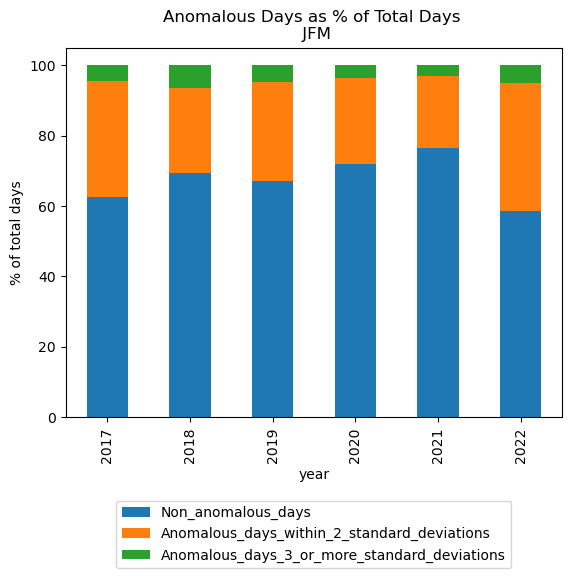

In [457]:
# FINAL PLOT Year
def anom_ct(seas):
    if seas == 'Annually':  
        std1 = df_final.groupby('std_bins').year.value_counts().unstack(0).reset_index()
    else: 
        std1 = df_final[df_final['season'] == seas].groupby('std_bins').year.value_counts().unstack(0).reset_index()
    
    std1 = std1.rename_axis(None, axis=1)
    std1['Total'] = std1.sum(axis=1)

    std1['Non_anomalous_days'] = (std1[1.0]/std1['Total'])*100
    std1['Anomalous_days_within_2_standard_deviations'] = (std1[2.0]/std1['Total'])*100
    std1['Anomalous_days_3_or_more_standard_deviations'] = (std1[3.0]/std1['Total'])*100

    plot = std1.plot(x='year', 
                     y = ['Non_anomalous_days', 'Anomalous_days_within_2_standard_deviations', 'Anomalous_days_3_or_more_standard_deviations'], 
                     kind='bar', 
                     ylabel = '% of total days',
                     stacked=True, 
                     title=f'Anomalous Days as % of Total Days \n {seas}')


    plot.legend(loc="upper center", bbox_to_anchor=(0.5,0), borderaxespad=6)
    plt.savefig(f'/home11/grad/2021/cs436778/general-circulation/project/data/barplot_year.png')

anom_ct('JFM')

/tmp/ipykernel_2343265/1546345214.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std1['Total'] = std1.sum(axis=1)
/tmp/ipykernel_2343265/1546345214.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std1['Total'] = std1.sum(axis=1)
/tmp/ipykernel_2343265/1546345214.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std1['Total'] = std1.sum(axis=1)
/tmp/ipykernel_2343265/1546345214.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None'

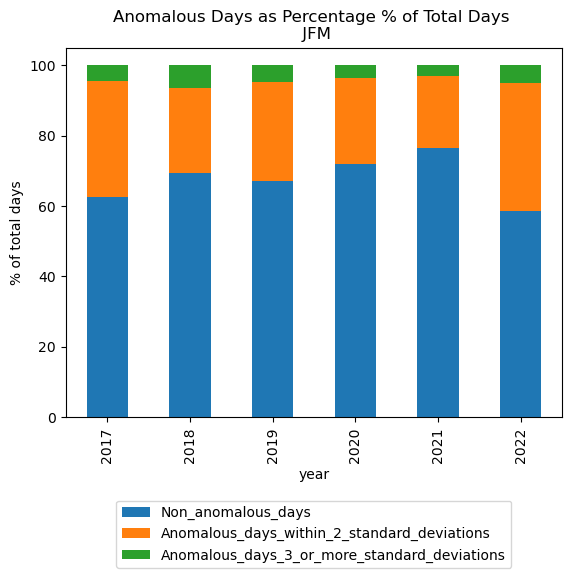

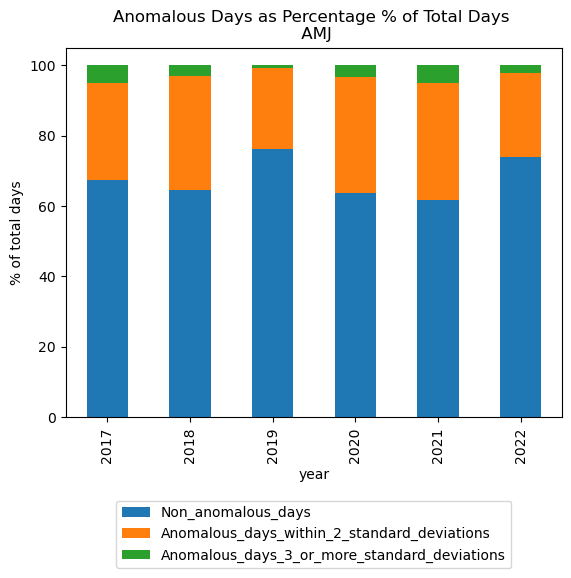

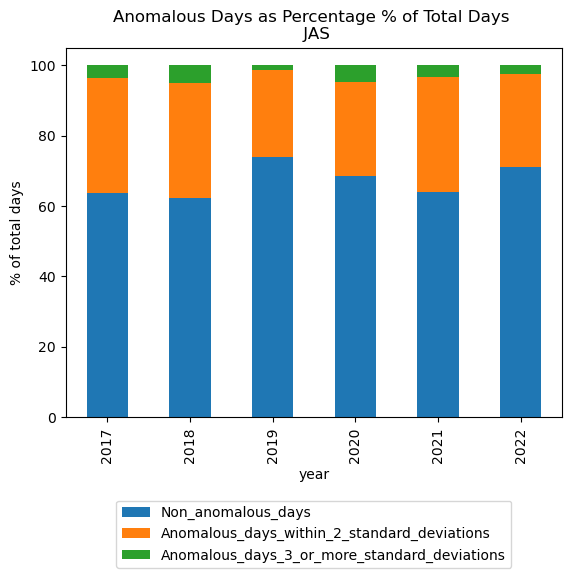

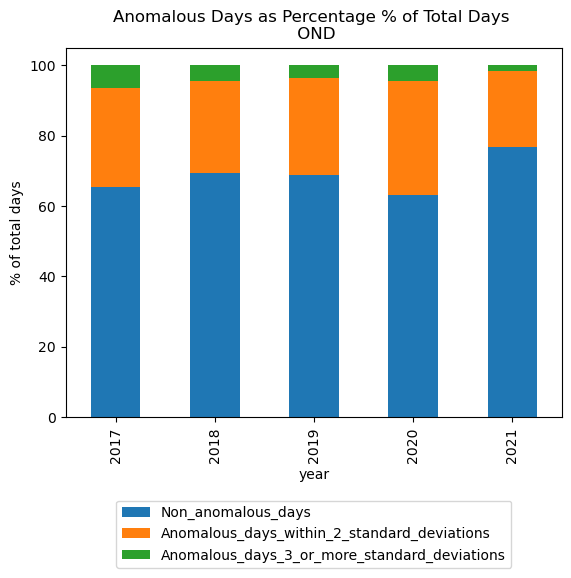

In [64]:
# FINAL PLOT season!!!
def anom_ct(seas):
    std1 = df_final[df_final['season'] == seas].groupby('std_bins').year.value_counts().unstack(0).reset_index()
    std1 = std1.rename_axis(None, axis=1)
    std1['Total'] = std1.sum(axis=1)

    # std1['Total'] = std1.sum(axis=0)

    std1['Non_anomalous_days'] = (std1[1.0]/std1['Total'])*100
    std1['Anomalous_days_within_2_standard_deviations'] = (std1[2.0]/std1['Total'])*100
    std1['Anomalous_days_3_or_more_standard_deviations'] = (std1[3.0]/std1['Total'])*100

    plot = std1.plot(x='year', 
                     y = ['Non_anomalous_days', 'Anomalous_days_within_2_standard_deviations', 'Anomalous_days_3_or_more_standard_deviations'], 
                     kind='bar', 
                     ylabel = '% of total days',
                     stacked=True, 
                     title=f'Anomalous Days as Percentage % of Total Days \n {seas}')


    plot.legend(loc="upper center", bbox_to_anchor=(0.5,0), borderaxespad=6)
    plt.savefig(f'/home11/grad/2021/cs436778/general-circulation/project/plots/barplot{seas}.png')

for season in seasons:
    anom_ct(season)

In [ ]:
len(df_final[~df_final['temp_2m[C]'].isna()])
df_final.shape

# Plot time series of anomalous temperatures 
- No longer just counting # of "anomaly days" but looking at avg anomaly temps broken out by cold and hot

In [959]:
# try averageing anomaly and not doing std

df_final[df_final['temp_2m[C]'].isna()]

df_for_measuring = df_final[['year', 'temp_2m[C]_anomaly']]
df_for_measuring = df_for_measuring[~df_for_measuring['temp_2m[C]_anomaly'].isna()]
df_cts = df_for_measuring.groupby(['year']).mean()
df_cts.reset_index(inplace=True)
df_cts.rename(columns = {'temp_2m[C]_anomaly':'mean_anomaly'}, inplace = True)


df_for_normalization = df_final[['year', 'temp_2m[C]_anomaly']]
df_for_normalization = df_for_normalization[~df_for_normalization['temp_2m[C]_anomaly'].isna()]
df_norm = df_for_normalization.groupby(['year', ]).count()
df_norm.reset_index(inplace=True)
df_norm.rename(columns = {'temp_2m[C]_anomaly':'count_totalyear'}, inplace = True)


mgd = df_cts.merge(df_norm, on = 'year', how = 'inner')
# mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

mgd

,year,mean_anomaly,count_totalyear
0,2017,-0.021305,43121
1,2018,-0.224203,45844
2,2019,-0.769905,45946
3,2020,0.557172,46021
4,2021,0.531249,45856
5,2022,-0.080823,32229


In [954]:
# try averageing anomaly and not doing std

df_final[df_final['temp_2m[C]'].isna()]

df_for_measuring = df_final[['year', 'temp_2m[C]_anomaly', 'season']]
df_for_measuring = df_for_measuring[~df_for_measuring['temp_2m[C]_anomaly'].isna()]
df_cts = df_for_measuring.groupby(['year', 'season']).mean()
df_cts.reset_index(inplace=True)
df_cts.rename(columns = {'temp_2m[C]_anomaly':'mean_anomaly'}, inplace = True)


df_for_normalization = df_final[['year', 'temp_2m[C]_anomaly', 'season']]
df_for_normalization = df_for_normalization[~df_for_normalization['temp_2m[C]_anomaly'].isna()]
df_norm = df_for_normalization.groupby(['year', 'season']).count()
df_norm.reset_index(inplace=True)
df_norm.rename(columns = {'temp_2m[C]_anomaly':'count_totalyear'}, inplace = True)


mgd = df_cts.merge(df_norm, on = ['year', 'season'], how = 'inner')
# mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

In [955]:
mgd

,year,season,mean_anomaly,count_totalyear
0,2017,DJF,0.514510,10065
1,2017,JJA,-1.051097,11270
2,2017,MAM,-0.230456,10460
3,2017,SON,0.720395,11326
4,2018,DJF,0.326057,11211
5,2018,JJA,0.417331,11592
6,2018,MAM,-0.779168,11592
7,2018,SON,-0.850673,11449
8,2019,DJF,-1.024506,11324
9,2019,JJA,-0.411954,11584


In [775]:
df_final

,date,year,month,season,monthday,station,temp_2m[C],temp_2m[C]_mean,temp_2m[C]_std,temp_2m[C]_anomaly,stds_away_act,stds_away,yes,no,two_std_ormore,one_std_ormore,std_bins,std_consec
0,2017-01-01,2017,01,JFM,01-01,ADDI,0.126042,-3.360558,6.257776,3.486600,0.557163,1.0,yes,no,False,True,1.0,1.0
1,2018-01-01,2018,01,JFM,01-01,ADDI,-16.729861,-3.360558,6.257776,-13.369303,2.136430,3.0,yes,no,True,True,3.0,2.0
2,2019-01-01,2019,01,JFM,01-01,ADDI,4.503125,-3.360558,6.257776,7.863683,1.256626,2.0,yes,no,True,True,2.0,2.0
3,2020-01-01,2020,01,JFM,01-01,ADDI,-2.948264,-3.360558,6.257776,0.412294,0.065885,1.0,yes,no,False,True,1.0,1.0
4,2021-01-01,2021,01,JFM,01-01,ADDI,-4.305903,-3.360558,6.257776,-0.945345,0.151067,1.0,yes,no,False,True,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262327,2018-12-31,2018,12,OND,12-31,YORK,-0.008333,-1.556117,6.352793,1.547784,0.243638,1.0,yes,no,False,True,1.0,1.0
262328,2019-12-31,2019,12,OND,12-31,YORK,2.273264,-1.556117,6.352793,3.829381,0.602787,1.0,yes,no,False,True,1.0,1.0
262329,2020-12-31,2020,12,OND,12-31,YORK,1.974306,-1.556117,6.352793,3.530423,0.555728,1.0,yes,no,False,True,1.0,1.0
262330,2021-12-31,2021,12,OND,12-31,YORK,5.020139,-1.556117,6.352793,6.576256,1.035176,2.0,yes,no,True,True,2.0,2.0


In [460]:
df_final

,date,year,month,season,monthday,station,temp_2m[C],temp_2m[C]_mean,temp_2m[C]_std,temp_2m[C]_anomaly,stds_away_precise,stds_away,std_bins,std_consec
0,2017-01-01,2017,01,JFM,01-01,ADDI,0.126042,-3.360558,6.257776,3.486600,0.557163,1.0,1.0,N
1,2018-01-01,2018,01,JFM,01-01,ADDI,-16.729861,-3.360558,6.257776,-13.369303,2.136430,3.0,3.0,Y
2,2019-01-01,2019,01,JFM,01-01,ADDI,4.503125,-3.360558,6.257776,7.863683,1.256626,2.0,2.0,Y
3,2020-01-01,2020,01,JFM,01-01,ADDI,-2.948264,-3.360558,6.257776,0.412294,0.065885,1.0,1.0,N
4,2021-01-01,2021,01,JFM,01-01,ADDI,-4.305903,-3.360558,6.257776,-0.945345,0.151067,1.0,1.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262327,2018-12-31,2018,12,OND,12-31,YORK,-0.008333,-1.556117,6.352793,1.547784,0.243638,1.0,1.0,N
262328,2019-12-31,2019,12,OND,12-31,YORK,2.273264,-1.556117,6.352793,3.829381,0.602787,1.0,1.0,N
262329,2020-12-31,2020,12,OND,12-31,YORK,1.974306,-1.556117,6.352793,3.530423,0.555728,1.0,1.0,N
262330,2021-12-31,2021,12,OND,12-31,YORK,5.020139,-1.556117,6.352793,6.576256,1.035176,2.0,2.0,Y


In [459]:
# FINAL TREND BY MONTH
# year month
# average anomaly not std

# df_final[df_final['temp_2m[C]'].isna()]

# all anom
df_for_measuring = df_final[['year', 'month', 'temp_2m[C]_anomaly']]
df_for_measuring = df_for_measuring[(~df_for_measuring['temp_2m[C]_anomaly'].isna()) & (~df_for_measuring['temp_2m[C]_anomaly'].isna())]
df_for_measuring['absanom'] = abs(df_for_measuring['temp_2m[C]_anomaly'])

df_mean_anom = df_for_measuring[['year', 'month', 'temp_2m[C]_anomaly']].groupby(['year', 'month']).mean()
df_mean_anom.reset_index(inplace=True)
df_mean_anom.rename(columns = {'temp_2m[C]_anomaly':'mean_anomaly'}, inplace = True)

df_forplot = df_for_measuring[['year', 'month', 'absanom']].groupby(['year', 'month']).mean()
df_forplot.reset_index(inplace=True)
df_forplot.rename(columns = {'absanom':'mean_absanomaly'}, inplace = True)
df_forplot['mean_reganomaly'] = df_mean_anom['mean_anomaly'] # add col from other group by mean df


# cold anom
df_cold = df_for_measuring[(df_for_measuring['temp_2m[C]_anomaly']<0)]
df_cold['absanom'] = abs(df_cold['temp_2m[C]_anomaly'])
df_mean_anom_cold = df_cold[['year', 'month', 'absanom']].groupby(['year', 'month']).mean()
df_mean_anom_cold.reset_index(inplace=True)
df_mean_anom_cold.rename(columns = {'absanom':'mean_absanomaly'}, inplace = True)
df_forplot['cold_absanomaly'] = df_mean_anom_cold['mean_absanomaly']

# add non abs cold anom
df_mean_anom_regcold = df_cold[['year', 'month', 'temp_2m[C]_anomaly']].groupby(['year', 'month']).mean()
df_mean_anom_regcold.reset_index(inplace=True)
df_mean_anom_regcold.rename(columns = {'temp_2m[C]_anomaly':'mean_anomaly'}, inplace = True)
df_forplot['cold_reganomaly'] = df_mean_anom_regcold['mean_anomaly']

# hot anom
df_hot = df_for_measuring[(df_for_measuring['temp_2m[C]_anomaly']>0)]
df_hot['absanom'] = abs(df_hot['temp_2m[C]_anomaly'])
df_mean_anom_hot = df_hot[['year', 'month', 'absanom']].groupby(['year', 'month']).mean()
df_mean_anom_hot.reset_index(inplace=True)
df_mean_anom_hot.rename(columns = {'absanom':'mean_absanomaly'}, inplace = True)
df_forplot['hot_absanomaly'] = df_mean_anom_hot['mean_absanomaly']

# add non abs hot anom
df_mean_anom_reghot = df_hot[['year', 'month', 'temp_2m[C]_anomaly']].groupby(['year', 'month']).mean()
df_mean_anom_reghot.reset_index(inplace=True)
df_mean_anom_reghot.rename(columns = {'temp_2m[C]_anomaly':'mean_anomaly'}, inplace = True)
df_forplot['hot_reganomaly'] = df_mean_anom_reghot['mean_anomaly']

df_forplot.reset_index(inplace=True)
# if want to add support, totals by yearmo, which are approx 126 sites *30 days
# df_for_normalization = df_final[['year', 'temp_2m[C]_anomaly', 'month']]
# df_for_normalization = df_for_normalization[~df_for_normalization['temp_2m[C]_anomaly'].isna()]
# df_norm = df_for_normalization.groupby(['year','month' ]).count()
# df_norm.reset_index(inplace=True)
# df_norm.rename(columns = {'temp_2m[C]_anomaly':'count_totalyear'}, inplace = True) # approx 3000 makes sense b/c 126sites*30 days in mo

# mgd = df_cts.merge(df_norm, on = ['year', 'month'], how = 'inner')
# # mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

# mgd['yearmo'] = mgd['year']+mgd['month']
# mgd

df_forplot['yearmo'] = df_forplot['year']+df_forplot['month']
df_forplot

/tmp/ipykernel_2343265/3273245551.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cold['absanom'] = abs(df_cold['temp_2m[C]_anomaly'])
/tmp/ipykernel_2343265/3273245551.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hot['absanom'] = abs(df_hot['temp_2m[C]_anomaly'])


,index,year,month,mean_absanomaly,mean_reganomaly,cold_absanomaly,cold_reganomaly,hot_absanomaly,hot_reganomaly,yearmo
0,0,2017,01,5.517891,2.744360,4.463437,-4.463437,5.993171,5.993171,201701
1,1,2017,02,4.222725,2.744897,2.573250,-2.573250,4.887172,4.887172,201702
2,2,2017,03,5.299832,-2.356012,5.619397,-5.619397,4.617005,4.617005,201703
3,3,2017,04,3.674476,2.714402,1.849473,-1.849473,4.314204,4.314204,201704
4,4,2017,05,3.012087,-1.003931,2.757645,-2.757645,3.693645,3.693645,201705
...,...,...,...,...,...,...,...,...,...,...
64,64,2022,05,3.190948,1.818026,1.974903,-1.974903,3.838837,3.838837,202205
65,65,2022,06,2.210504,-0.499581,2.414870,-2.414870,1.949212,1.949212,202206
66,66,2022,07,1.999852,0.043628,1.885220,-1.885220,2.123457,2.123457,202207
67,67,2022,08,2.103171,0.867557,1.810749,-1.810749,2.254612,2.254612,202208


#### Correlations!

In [464]:
df_forplot['cold_absanomaly'].corr(df_forplot['hot_absanomaly'])
print(anom_cold.corr(anom_hot))

0.492172780654303


In [463]:
print(df_forplot['index'].corr(df_forplot['mean_reganomaly']) )# low correlation. this is line of best fit in green on plot
print(df_forplot['index'].corr(df_forplot['mean_absanomaly']) )# low correlation. this is line of best fit in green on plot

0.10246444278094712
-0.19676802077770128


In [67]:
# if want to save out as csv! Like did for correlations google sheets

# dfcold = anom_cold.to_frame()
# dfcold.to_csv('cold.csv')

# dfhot= anom_hot.to_frame()
# dfhot.to_csv('hot.csv')

# dftime= time_plot.to_frame()
# dftime.to_csv('yearmo.csv')


# dfavg= anom_plot.to_frame()
# dfavg.to_csv('avg.csv')


# dfavg= df_forplot['mean_anomaly'].to_frame()
# dfavg.to_csv('avg_not_absval.csv')

In [114]:
# Example done in spot check google sheet!
df_forplot[df_forplot['yearmo']=='201801']

,year,month,mean_absanomaly,mean_reganomaly,cold_absanomaly,cold_reganomaly,hot_absanomaly,hot_reganomaly,yearmo
12,2018,01,6.900204,-1.38503,7.417994,-7.417994,6.245315,6.245315,201801


### Plots time series

In [474]:
def plot_tanom_timeseries(xplot,yavg, ycold, yhot, title1):

    ## Create figure of a particular size
    fig = plt.figure(figsize=(16, 4))

    # add plots 
    ax1 = fig.add_subplot(1, 1, 1)

    ax1.plot(xplot, yavg, label='Avg Anomalous Temp [C]', color='black',linewidth=2, markersize = 6, marker='o', linestyle = '--') #, marker='o'
    ax1.plot(xplot, ycold, label='Cool Anomalous Temp [C]', color='blue',linewidth=1, markersize = 6, marker='o') #, marker='o'
    ax1.plot(xplot, yhot, label='Warm Anomalous Temp [C]', color='red',linewidth=1, markersize = 6, marker='o') #, marker='o'
    
    # add line of best fit
    x = np.array(range(0, len(time_plot)))
    y = np.array(anom_plot)
    m, b = np.polyfit(x, y, 1) 
    print(m)
    ax1.plot(x, m*x + b, color = 'green', linewidth = 1, linestyle = '--', label='Avg Anomaly Line of Best Fit')

    
    # add title, labels, ticks, etc
    ax1.set_title(f'{title1} \n Includes All NYSM Sites \n 1/1/17 - 9/13/22  ', size = 16)
    ax1.set_xlabel('Year', size = 14)
    ax1.set_ylabel('Temp Anomaly ($^\circ$C)', size = 14)
    ax1.tick_params(axis='x', labelrotation = 70, labelsize=10)
    ax1.tick_params(axis='y',  labelsize=14)
    ax1.grid(color = 'lightgrey', linestyle = '--', linewidth = 0.5)
    ax1.legend(loc='upper right')  
    

In [469]:
m

-0.011008628595438148

In [458]:
anom_cold

0     538
1     315
2     541
3     437
4     352
5     521
6     616
7     243
8     376
9     127
10    158
11    334
12    263
13    582
14    356
15    654
16     86
17    706
18    551
19    104
20    878
21    229
22    193
Name: RawCount100, dtype: int64

In [478]:
df_forplot

,index,year,month,mean_absanomaly,mean_reganomaly,cold_absanomaly,cold_reganomaly,hot_absanomaly,hot_reganomaly,yearmo
0,0,2017,01,5.517891,2.744360,4.463437,-4.463437,5.993171,5.993171,201701
1,1,2017,02,4.222725,2.744897,2.573250,-2.573250,4.887172,4.887172,201702
2,2,2017,03,5.299832,-2.356012,5.619397,-5.619397,4.617005,4.617005,201703
3,3,2017,04,3.674476,2.714402,1.849473,-1.849473,4.314204,4.314204,201704
4,4,2017,05,3.012087,-1.003931,2.757645,-2.757645,3.693645,3.693645,201705
...,...,...,...,...,...,...,...,...,...,...
64,64,2022,05,3.190948,1.818026,1.974903,-1.974903,3.838837,3.838837,202205
65,65,2022,06,2.210504,-0.499581,2.414870,-2.414870,1.949212,1.949212,202206
66,66,2022,07,1.999852,0.043628,1.885220,-1.885220,2.123457,2.123457,202207
67,67,2022,08,2.103171,0.867557,1.810749,-1.810749,2.254612,2.254612,202208


-0.011008628595438148


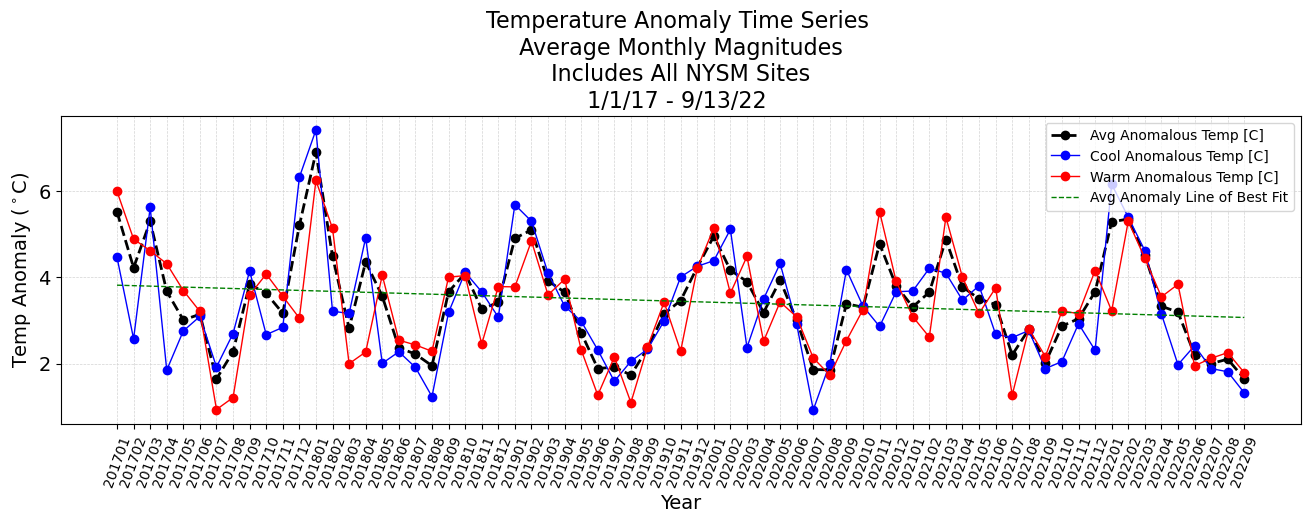

In [475]:
time_plot = df_forplot['yearmo']
anom_plot = df_forplot['mean_absanomaly']
anom_cold = df_forplot['cold_absanomaly']
anom_hot = df_forplot['hot_absanomaly']

plot_tanom_timeseries(time_plot, anom_plot, anom_cold, anom_hot, 'Temperature Anomaly Time Series \n Average Monthly Magnitudes') 

0.008061850240471463


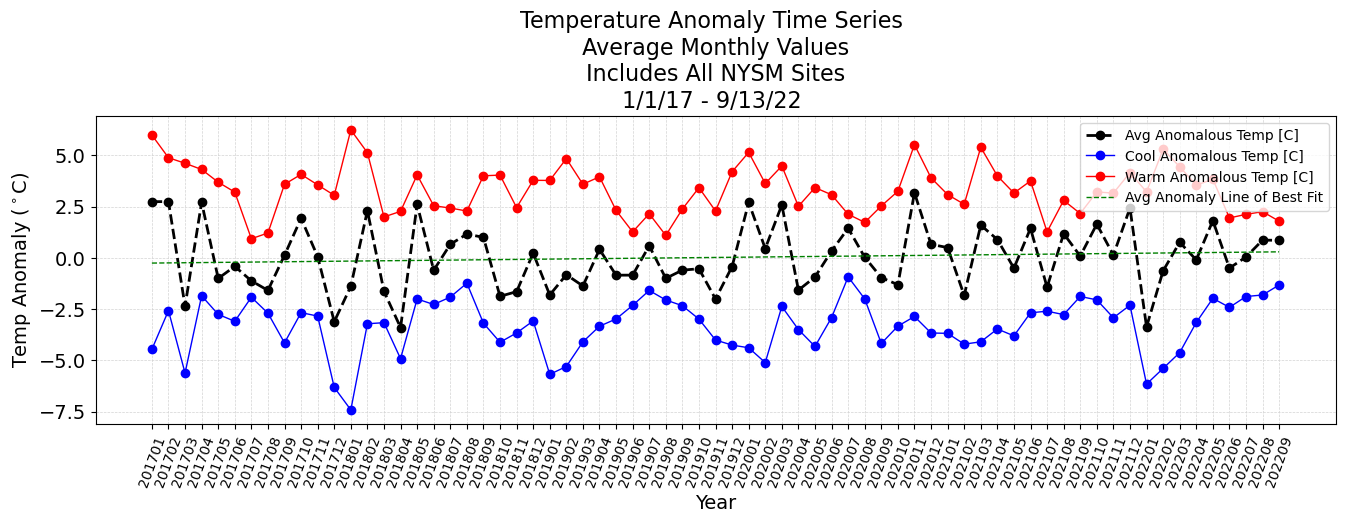

In [476]:
time_plot = df_forplot['yearmo']
anom_plot = df_forplot['mean_reganomaly']
anom_cold = df_forplot['cold_reganomaly']
anom_hot = df_forplot['hot_reganomaly']

plot_tanom_timeseries(time_plot, anom_plot, anom_cold, anom_hot, 'Temperature Anomaly Time Series \n Average Monthly Values') 

In [477]:
m

-0.011008628595438148

In [195]:
# df_jfm = df_final[(~df_final['temp_2m[C]_anomaly'].isna()) & ((df_final['month'] == '01') | (df_final['month'] == '02') | (df_final['month'] == '03'))]
df_jfm = df_final[(~df_final['temp_2m[C]_anomaly'].isna()) & ((df_final['month'] == '01'))]

print(len(df_jfm))
df_jfm.to_csv('jan.csv')

22680


# Count "prolonged" , i.e consecutive days, come back to

# Consecutive days -- come back to

In [203]:
# define function that quantifies the amount of prolonged anomalous events
# counts the amount of days in a year when: 
#1) the std 2 or more, 
#2) it is a part of a sequence of consecutive days where the anomalous temp was also above two stds

In [364]:
# for stations and years
stations = df_final['station'].unique().tolist()
years = df_final['year'].unique().tolist()

# for counting sequence of days to count it as "prolonged"
threshold = 4 # this is min length of sequence to count
var_to_count = 'Y'

site_year_entry = []

for site in stations:
    for yr in years:
        #append site and year for tracking 
        # subset df and make sure it's ordered by date so that cumulative sum works
        df_site_yr = df_final[(df_final['station']==site)& (df_final['year']==yr)& ~(df_final['stds_away'].isna())]
        df_site_yr = df_site_yr.sort_values(by=['date'])
        df_site_yr = df_site_yr.reset_index()
        total_site_yr = len(df_site_yr) # used for looping and for appending for normalization
        my_out = [0 for i in range(0, total_site_yr)]
        # count number of consecutive days
        counter = 0 # number of times var_to_count shows up
        my_data = df_site_yr['std_consec'].to_list()
        my_out = [0 for i in range(0, len(my_data))] # this is the output list... 1 means count, 0 means don't count; initially all is 0.
        counter = 0 # number of times var_to_count shows up
        for i in range(0, len(my_data)):
            if my_data[i] == var_to_count:
                counter += 1
                if counter == threshold: # if it's exactly the threshold, go back and fill in yesses.
                    for j in range(0, counter):
                        my_out[i - j] = 1 # since we're at the threshold, set the previous values to 1 now
                if counter > threshold: # now we just keep adding 1s
                    my_out[i] = 1
            else: # if the variable doesn't show up
                counter = 0
        amt = sum(my_out)
        site_year_entry.append((site,yr,total_site_yr, amt))

df_consec_cts = pd.DataFrame(site_year_entry , columns = ['Station', 'Year', 'Days', 'Count_Consec3day_Std2'])

df_consec_cts['relative_consec3d_std2'] = (df_consec_cts['Count_Consec3day_Std2']/df_consec_cts['Days'] )*100


In [368]:
df_consec_cts[200:206]
df_consec_cts.dtypes

Station                    object
Year                       object
Days                        int64
Count_Consec3day_Std2       int64
relative_consec3d_std2    float64
dtype: object

In [351]:
# x = df_consec_cts[df_consec_cts['Station'] == 'AllStations']['Year']
# y = df_consec_cts[df_consec_cts['Station'] == 'AllStations']['relative_consec3d_std2']

# y

In [398]:
 df_site_yr

,date,year,month,season,monthday,station,temp_2m[C],temp_2m[C]_mean,temp_2m[C]_std,temp_2m[C]_anomaly,stds_away_precise,stds_away,std_bins,std_consec
0,2017-01-01,2017,01,JFM,01-01,ADDI,0.126042,-3.360558,6.257776,3.486600,0.557163,1.0,1.0,N
201954,2017-01-01,2017,01,JFM,01-01,SHER,0.265972,-3.714812,6.208273,3.980784,0.641206,1.0,1.0,N
199872,2017-01-01,2017,01,JFM,01-01,SCIP,-0.324373,-3.538816,6.016600,3.214444,0.534262,1.0,1.0,N
29148,2017-01-01,2017,01,JFM,01-01,BROO,-1.050694,-4.677995,6.291711,3.627301,0.576521,1.0,1.0,N
197790,2017-01-01,2017,01,JFM,01-01,SCHU,2.082292,-3.657184,6.658549,5.739476,0.861971,1.0,1.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56748,2017-03-31,2017,03,JFM,03-31,COBL,0.810069,3.708480,4.315318,-2.898410,0.671656,1.0,1.0,N
40092,2017-03-31,2017,03,JFM,03-31,CAMD,2.038889,3.465766,4.023510,-1.426877,0.354635,1.0,1.0,N
29682,2017-03-31,2017,03,JFM,03-31,BROO,0.498958,2.546308,4.530959,-2.047350,0.451858,1.0,1.0,N
65076,2017-03-31,2017,03,JFM,03-31,COPE,1.769444,2.743785,4.246315,-0.974340,0.229456,1.0,1.0,N


In [435]:
# for stations and years
stations = df_final['station'].unique().tolist()
years = df_final['year'].unique().tolist()

# for counting sequence of days to count it as "prolonged"
threshold = 4 # this is min length of sequence to count
var_to_count = 'Y'

site_year_entry = []

# for site in stations:
for yr in years:
    for season in seasons:
        #append site and year for tracking 
        # subset df and make sure it's ordered by date so that cumulative sum works
        df_site_yr = df_final[(df_final['year']==yr)& ~(df_final['stds_away'].isna()) & (df_final['season']==season)]
        df_site_yr = df_site_yr.sort_values(by=['date'])
        df_site_yr = df_site_yr.sort_values(by=['station'])
        df_site_yr = df_site_yr.reset_index()
        total_site_yr = (len(df_site_yr) if len(df_site_yr)>0 else 1) # used for looping and for appending for normalization
        my_out = [0 for i in range(0, total_site_yr)]
        # count number of consecutive days
        counter = 0 # number of times var_to_count shows up
        my_data = df_site_yr['std_consec'].to_list()
        my_out = [0 for i in range(0, len(my_data))] # this is the output list... 1 means count, 0 means don't count; initially all is 0.
        counter = 0 # number of times var_to_count shows up
        for i in range(0, len(my_data)):
            if my_data[i] == var_to_count:
                counter += 1
                if counter == threshold: # if it's exactly the threshold, go back and fill in yesses.
                    for j in range(0, counter):
                        my_out[i - j] = 1 # since we're at the threshold, set the previous values to 1 now
                if counter > threshold: # now we just keep adding 1s
                    my_out[i] = 1
            else: # if the variable doesn't show up
                counter = 0
        amt = sum(my_out)
        relative_consec_4d_2std = (amt/total_site_yr)*10000
        site_year_entry.append((yr, season,total_site_yr, amt, relative_consec_4d_2std))




In [436]:
df_consec_cts_season = pd.DataFrame(site_year_entry , columns = ['Year', 'Season', 'Days', 'Count_Consec3day_Std2', 'relative_consec3d_std2'])

# df_consec_cts['relative_consec3d_std2'] = (df_consec_cts['Count_Consec3day_Std2']/df_consec_cts['Days'] )*100

In [437]:
df_consec_cts_season['YearSeason'] = df_consec_cts_season['Year']+"_"+df_consec_cts_season['Season']
df_consec_cts_season

df_consec_cts_season['RawCount100'] = df_consec_cts_season['Count_Consec3day_Std2']
df_consec_cts_season

,Year,Season,Days,Count_Consec3day_Std2,relative_consec3d_std2,YearSeason,RawCount100
0,2017,JFM,9607,538,560.008327,2017_JFM,538
1,2017,AMJ,10715,315,293.980401,2017_AMJ,315
2,2017,JAS,11382,541,475.311896,2017_JAS,541
3,2017,OND,11417,437,382.762547,2017_OND,437
4,2018,JFM,11236,352,313.278747,2018_JFM,352
5,2018,AMJ,11466,521,454.386883,2018_AMJ,521
6,2018,JAS,11592,616,531.400966,2018_JAS,616
7,2018,OND,11550,243,210.389610,2018_OND,243
8,2019,JFM,11329,376,331.891606,2019_JFM,376
9,2019,AMJ,11458,127,110.839588,2019_AMJ,127


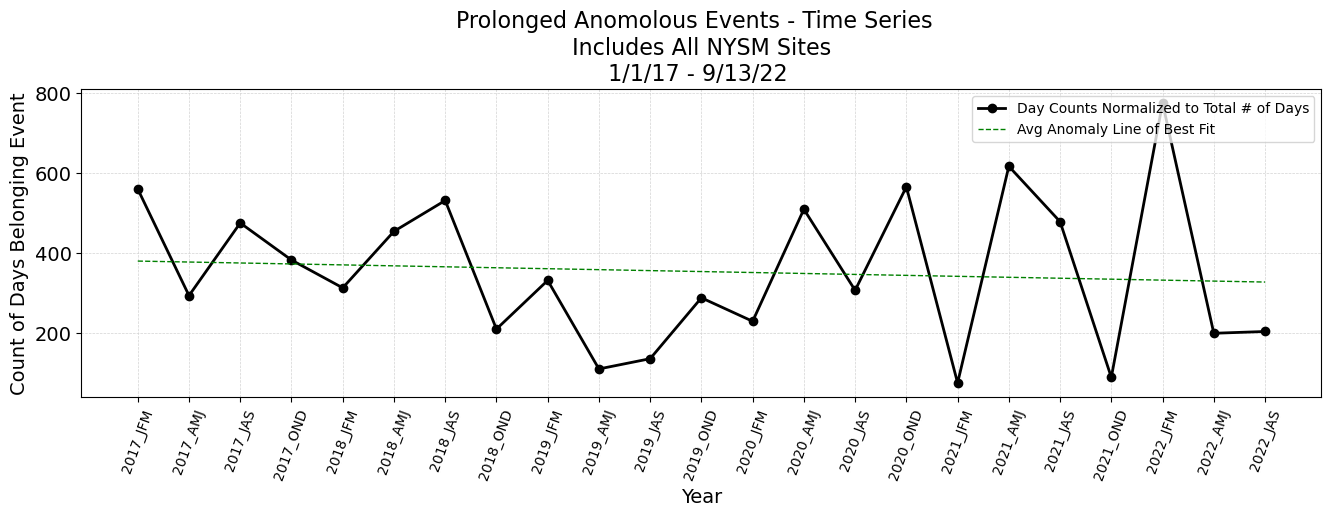

In [439]:
def plot_tanom_timeseries(xplot,yavg, ycold, yhot, title1):

    ## Create figure of a particular size
    fig = plt.figure(figsize=(16, 4))

    # add plots 
    ax1 = fig.add_subplot(1, 1, 1)

    ax1.plot(xplot, yavg, label = 'Day Counts Normalized to Total # of Days', color='black',linewidth=2, markersize = 6, marker='o') #, marker='o'
    # ax1.plot(xplot, ycold, label= 'Day Counts / 100 (but not normalized)', color='blue',linewidth=1, markersize = 6, marker='o') #, marker='o'
    # ax1.plot(xplot, yhot, label='Warm Anomalous Temp [C]', color='red',linewidth=1, markersize = 6, marker='o') #, marker='o'
    
    # add line of best fit
    x = np.array(range(0, len(xplot)))
    y = np.array(yavg)
    m, b = np.polyfit(x, y, 1) 
    ax1.plot(x, m*x + b, color = 'green', linewidth = 1, linestyle = '--', label='Line of Best Fit')

    
    # add title, labels, ticks, etc
    ax1.set_title(f'{title1} \n Includes All NYSM Sites \n 1/1/17 - 9/13/22  ', size = 16)
    ax1.set_xlabel('Year', size = 14)
    ax1.set_ylabel('Count of Days Belonging Event', size = 14)
    ax1.tick_params(axis='x', labelrotation = 70, labelsize=10)
    ax1.tick_params(axis='y',  labelsize=14)
    ax1.grid(color = 'lightgrey', linestyle = '--', linewidth = 0.5)
    ax1.legend(loc='upper right')  
    
time_plot = df_consec_cts_season['YearSeason'][0:23] # remove OND
anom_plot = df_consec_cts_season['relative_consec3d_std2'][0:23]
anom_cold = df_consec_cts_season['RawCount100'][0:23]


plot_tanom_timeseries(time_plot, anom_plot, anom_cold, anom_hot, 'Prolonged Anomolous Events - Time Series ') 

In [421]:
anom_plot

0     5.600083
1     2.939804
2     4.753119
3     3.827625
4     3.132787
5     4.543869
6     5.314010
7     2.103896
8     3.318916
9     1.108396
10    1.364421
11    2.884532
12    2.298148
13    5.095876
14    3.071613
15    5.654505
16    0.759382
17    6.167555
18    4.785479
19    0.898876
20    7.750022
21    1.999127
22    2.043409
Name: relative_consec3d_std2, dtype: float64

In [607]:
g

260255     1
260267     3
260315     5
260339     7
260345     7
          ..
261569    89
261599    91
261605    91
261623    93
261695    95
Name: std_consec, Length: 92, dtype: int64

In [608]:
x = df_consec_cts['Year']
y = df_consec_cts['relative_consec3d_std2']

y

0    4.657534
1    3.561644
2    3.287671
3    2.459016
4    3.287671
5    4.296875
Name: relative_consec3d_std2, dtype: float64

In [634]:
# for by seasons and years
seasons = df_final['season'].unique().tolist()
years = df_final['year'].unique().tolist()

season_year_entry = []

for seas in seasons:
    print(seas)
    for yr in years:
        #append site and year for tracking 
        # subset df and make sure it's ordered by date so that cumulative sum works
        df_site_yr = df_final[(df_final['season']==seas)& (df_final['year']==yr)& ~(df_final['stds_away'].isna())]
        df_site_yr = df_site_yr.sort_values(by=['date'])
        # get count of total non null days for relative calc (rather than just count totals which may differ)
        total_site_yr = len(df_site_yr)
        # count the number of times that there are 3 or more consecutive days where temp was 2 std or more away from mean
        # reference: https://stackoverflow.com/questions/64769277/how-to-count-occurrences-of-3-consecutive-1-values-in-dataframe-column
        g = df_site_yr['std_consec'].ne(df_site_yr['std_consec'].shift()).cumsum()
        g = g[df_site_yr['std_consec'].eq(2)]
        amt = g.groupby(g).count().ge(3).sum()*3
        consecdays3_std2.append(amt)
        season_year_entry.append((seas,yr,total_site_yr, amt))

df_consec_cts = pd.DataFrame(season_year_entry , columns = ['Season', 'Year', 'Days', 'Count_Consec3day_Std2'])

df_consec_cts['relative_consec3d_std2'] = (df_consec_cts['Count_Consec3day_Std2']/df_consec_cts['Days'] )*100


JFM
AMJ
JAS
OND


In [638]:
years = df_consec_cts[df_consec_cts['Season'] == 'JAS']['Year']

jfm = df_consec_cts[df_consec_cts['Season'] == 'JFM']['relative_consec3d_std2']
amj= df_consec_cts[df_consec_cts['Season'] == 'AMJ']['relative_consec3d_std2']
jas = df_consec_cts[df_consec_cts['Season'] == 'JAS']['relative_consec3d_std2']
ond = df_consec_cts[df_consec_cts['Season'] == 'OND']['relative_consec3d_std2']


# jfm = df_consec_cts[df_consec_cts['Season'] == 'JFM']['Count_Consec3day_Std2']
# amj= df_consec_cts[df_consec_cts['Season'] == 'AMJ']['Count_Consec3day_Std2']
# jas = df_consec_cts[df_consec_cts['Season'] == 'JAS']['Count_Consec3day_Std2']
# ond = df_consec_cts[df_consec_cts['Season'] == 'OND']['Count_Consec3day_Std2']


In [636]:
df_consec_cts

,Season,Year,Days,Count_Consec3day_Std2,relative_consec3d_std2
0,JFM,2017,9607,474,4.933902
1,JFM,2018,11236,600,5.339979
2,JFM,2019,11329,711,6.275929
3,JFM,2020,11444,693,6.055575
4,JFM,2021,11325,525,4.635762
5,JFM,2022,11329,993,8.765116
6,AMJ,2017,10715,654,6.103593
7,AMJ,2018,11466,867,7.561486
8,AMJ,2019,11458,657,5.733985
9,AMJ,2020,11421,1035,9.062254


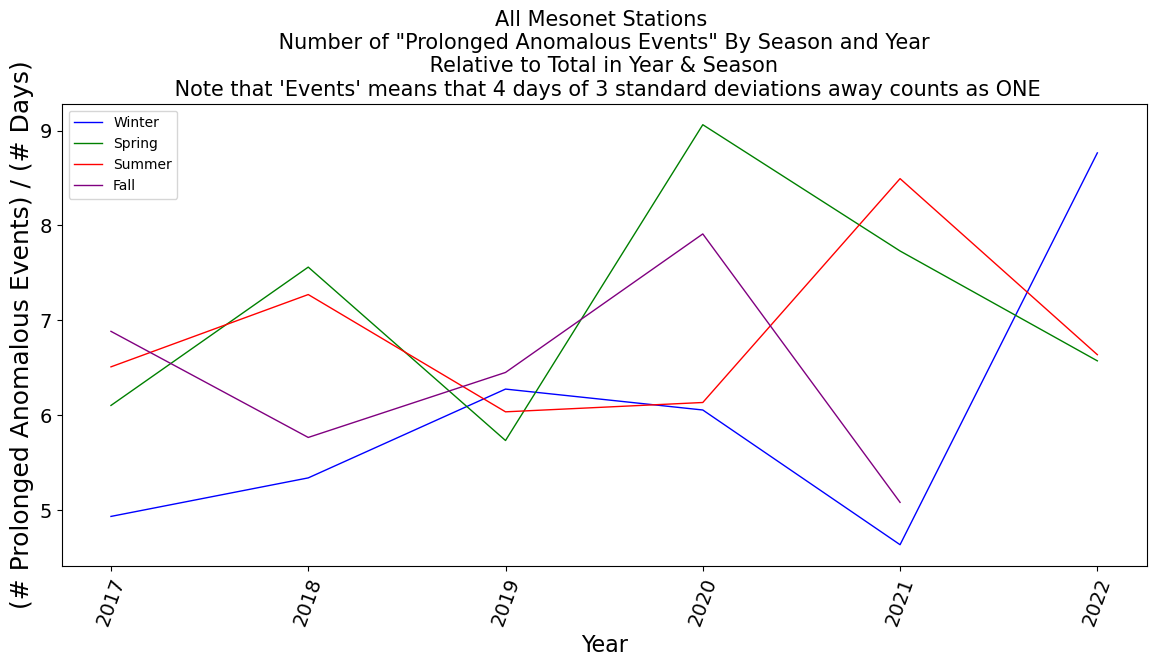

In [639]:
import matplotlib.pyplot as plt

## Create figure of a particular size
fig = plt.figure(figsize=(14, 6))

## TS Karl
# add plots for TS Karl windspeed
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(years, jfm, label='Winter', color='blue',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(years, amj, label='Spring', color='green',linewidth=1, markersize = 6) # , marker='o'
ax1.plot(years, jas, label='Summer', color='red',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(years, ond, label='Fall', color='purple',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(years, annual, label='Annual', color='black',linewidth=2, linestyle='--', markersize = 6) #, marker='o'


ax1.set_title('All Mesonet Stations \n Number of \"Prolonged Anomalous Events\" By Season and Year \n Relative to Total in Year & Season \n Note that \'Events\' means that 4 days of 3 standard deviations away counts as ONE', size = 15)
ax1.set_xlabel('Year', size = 16)
ax1.set_ylabel('(# Prolonged Anomalous Events) / (# Days)', size = 18)
ax1.tick_params(axis='x', labelrotation = 70, labelsize=14)
ax1.tick_params(axis='y',  labelsize=14)

ax1.legend(loc='upper left')

In [541]:
df_consec_cts 

,Station,Year,Days,Count_Consec3day_Std2,relative_consec3d_std2
0,ADDI,2017,360,20,5.56%
1,ADDI,2018,365,14,3.84%
2,ADDI,2019,365,14,3.84%
3,ADDI,2020,366,12,3.28%
4,ADDI,2021,365,14,3.84%
...,...,...,...,...,...
751,YORK,2018,365,13,3.56%
752,YORK,2019,365,12,3.29%
753,YORK,2020,366,9,2.46%
754,YORK,2021,365,12,3.29%


In [525]:
consecdays3_std2

[13, 13, 16, 13, 14, 10, 12, 13, 15, 17, 13, 10, 14, 11]

In [484]:
df_site = df_final[(df_final['station']=='ELMI')& (df_final['year']=='2020')]
df_site = df_final[(df_final['station']=='ELMI')& (df_final['year']=='2020') &  ~(df_final['temp_2m[C]'].isna()) ]
df_site = df_site.sort_values(by=['date'])

In [485]:
df_site

,date,year,month,season,monthday,station,temp_2m[C],temp_2m[C]_mean,temp_2m[C]_std,temp_2m[C]_anomaly,stds_away_act,stds_away,yes,no,two_std_ormore,one_std_ormore,std_bins
89529,2020-01-01,2020,01,JFM,01-01,ELMI,-1.115972,-2.295588,5.907926,1.179616,0.199667,1.0,yes,no,False,True,1.0
89535,2020-01-02,2020,01,JFM,01-02,ELMI,-0.226736,-2.562737,5.946249,2.336001,0.392853,1.0,yes,no,False,True,1.0
89541,2020-01-03,2020,01,JFM,01-03,ELMI,4.740972,-2.626418,5.838653,7.367390,1.261830,2.0,yes,no,True,True,2.0
89547,2020-01-04,2020,01,JFM,01-04,ELMI,3.315972,-2.465872,6.048512,5.781844,0.955912,1.0,yes,no,False,True,1.0
89553,2020-01-05,2020,01,JFM,01-05,ELMI,-0.204167,-2.152976,6.319824,1.948809,0.308364,1.0,yes,no,False,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91585,2020-12-27,2020,12,OND,12-27,ELMI,-3.973958,-1.310388,5.572632,-2.663571,0.477974,1.0,yes,no,False,True,1.0
91590,2020-12-28,2020,12,OND,12-28,ELMI,1.383681,-1.256053,5.628356,2.639734,0.469006,1.0,yes,no,False,True,1.0
91595,2020-12-29,2020,12,OND,12-29,ELMI,-1.860417,-1.107460,5.484200,-0.752957,0.137296,1.0,yes,no,False,True,1.0
91600,2020-12-30,2020,12,OND,12-30,ELMI,-3.218750,-1.319333,5.776133,-1.899417,0.328839,1.0,yes,no,False,True,1.0


In [469]:
g = df_site['stds_away'].ne(df_site['stds_away'].shift()).cumsum()
# print(type(g))
# print(len(g))
print(g)
g = g[df_site['stds_away'].eq(2)]
# print(type(g))
# print(len(g))
amt = g.groupby(g).count().ge(3).sum()
print(type(amt))
amt

5        1
11       2
17       2
23       2
29       2
        ..
1511    97
1517    97
1523    97
1529    97
1535    97
Name: stds_away, Length: 256, dtype: int64
<class 'numpy.int64'>


10

In [359]:
df_final[df_final['stds_away'] == 3.0]

,date,year,month,season,monthday,station,temp_2m[C],temp_2m[C]_mean,temp_2m[C]_std,temp_2m[C]_anomaly,stds_away_act,stds_away,yes,no,two_std_ormore,one_std_ormore,std_bins
1,2018-01-01,2018,01,JFM,01-01,ADDI,-16.729861,-3.360558,6.257776,-13.369303,2.136430,3.0,yes,no,True,True,3.0
25,2018-01-05,2018,01,JFM,01-05,ADDI,-17.347917,-3.303049,6.468904,-14.044868,2.171136,3.0,yes,no,True,True,3.0
31,2018-01-06,2018,01,JFM,01-06,ADDI,-18.389583,-3.275470,6.338393,-15.114113,2.384534,3.0,yes,no,True,True,3.0
37,2018-01-07,2018,01,JFM,01-07,ADDI,-16.949653,-3.492762,6.334616,-13.456891,2.124342,3.0,yes,no,True,True,3.0
63,2020-01-11,2020,01,JFM,01-11,ADDI,9.348958,-4.279610,6.055339,13.628569,2.250670,3.0,yes,no,True,True,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262306,2017-12-27,2017,12,OND,12-27,YORK,-14.885417,-0.774548,5.781031,-14.110869,2.440891,3.0,yes,no,True,True,3.0
262311,2017-12-28,2017,12,OND,12-28,YORK,-15.395833,-0.754631,5.788673,-14.641202,2.529285,3.0,yes,no,True,True,3.0
262316,2017-12-29,2017,12,OND,12-29,YORK,-14.762500,-0.921793,5.913464,-13.840707,2.340541,3.0,yes,no,True,True,3.0
262326,2017-12-31,2017,12,OND,12-31,YORK,-15.055903,-1.556117,6.352793,-13.499785,2.125016,3.0,yes,no,True,True,3.0


In [242]:
std2

,year,ratio_within_2std,ratio_morethan_2std
0,2017,95.440313,4.559687
1,2018,95.279409,4.720591
2,2019,97.342901,2.657099
3,2020,95.934166,4.065834
4,2021,96.734073,3.265927
5,2022,96.723090,3.276910


In [171]:
std3 = std2.rename(columns={True:'Success'})
std3

two_std_ormore,index,year,False,Success
0,0,2017,43893,2097
1,1,2018,43819,2171
2,2,2019,44768,1222
3,3,2020,44241,1875
4,4,2021,44488,1502
5,5,2022,31199,1057


In [ ]:
t = df_final[df_final['season'] == 'JFM'].groupby('one_std_ormore').year.value_counts().unstack(0).reset_index()


In [275]:
std_1 = df_final[df_final['season'] == 'JFM'].groupby('one_std_ormore').year.value_counts().unstack(0).reset_index()
std_1 = std_1.rename(columns={True:'outside_1std', False:'within_1std'})
std_1

std_1 = df_final[df_final['season'] == 'JFM'].groupby('one_std_ormore').year.value_counts().unstack(0).reset_index()
std_1 = std_1.rename(columns={True:'outside_1std', False:'within_1std'})
std_1

one_std_ormore,year,within_1std,outside_1std
0,2017,7748,3592
1,2018,7886,3454
2,2019,7607,3733
3,2020,8270,3196
4,2021,8665,2675
5,2022,6656,4684


In [352]:
print(len(df_final[(df_final['season']=='JFM')&(df_final['year']=='2017')&(df_final['temp_2m[C]'].isna())]['temp_2m[C]'][df_final['temp_2m[C]'].isna()]))

1733


In [340]:
df_final[ (df_final['season']=='JFM')]

,date,year,month,season,monthday,station,temp_2m[C],temp_2m[C]_mean,temp_2m[C]_std,temp_2m[C]_anomaly,stds_away_act,stds_away,yes,no,two_std_ormore,one_std_ormore,std_bins
0,2017-01-01,2017,01,JFM,01-01,ADDI,0.126042,-3.360558,6.257776,3.486600,0.557163,1.0,yes,no,False,True,1.0
1,2018-01-01,2018,01,JFM,01-01,ADDI,-16.729861,-3.360558,6.257776,-13.369303,2.136430,3.0,yes,no,True,True,3.0
2,2019-01-01,2019,01,JFM,01-01,ADDI,4.503125,-3.360558,6.257776,7.863683,1.256626,2.0,yes,no,True,True,2.0
3,2020-01-01,2020,01,JFM,01-01,ADDI,-2.948264,-3.360558,6.257776,0.412294,0.065885,1.0,yes,no,False,True,1.0
4,2021-01-01,2021,01,JFM,01-01,ADDI,-4.305903,-3.360558,6.257776,-0.945345,0.151067,1.0,yes,no,False,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260786,2019-03-31,2019,03,JFM,03-31,YORK,3.104514,5.216674,4.403412,-2.112160,0.479665,1.0,yes,no,False,True,1.0
260787,2020-03-31,2020,03,JFM,03-31,YORK,5.492708,5.216674,4.403412,0.276034,0.062686,1.0,yes,no,False,True,1.0
260788,2021-03-31,2021,03,JFM,03-31,YORK,12.603125,5.216674,4.403412,7.386451,1.677438,2.0,yes,no,True,True,2.0
260789,2022-03-31,2022,03,JFM,03-31,YORK,12.514931,5.216674,4.403412,7.298256,1.657409,2.0,yes,no,True,True,2.0


In [56]:
# spot check that counts in group by df (for bar chart) are right

x=(len(df_final[(df_final['year']=='2017')  & (df_final['season']=='JFM') & ~(df_final['temp_2m[C]_std'].isna())]))
y=(len(df_final[(df_final['season']=='JFM')&(df_final['year']=='2017')&(df_final['temp_2m[C]'].isna())]['temp_2m[C]'][df_final['temp_2m[C]'].isna()]))

print(x-y)

9607


# Old bar plots with sites,etc

/tmp/ipykernel_1425488/1068016749.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std1['Total'] = std1.sum(axis=1)


<AxesSubplot:title={'center':'Percentage % of ANDE Days within Standard Deviation Bins'}, xlabel='year'>

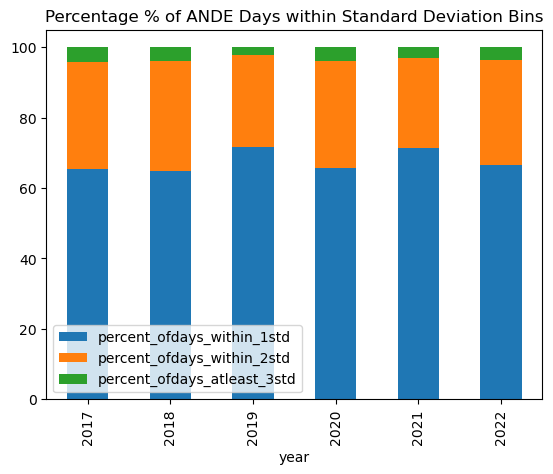

In [393]:
std1 = df_final[df_final['station'] == 'ANDE'].groupby('std_bins').year.value_counts().unstack(0).reset_index()
std1 = std1.rename_axis(None, axis=1)
std1['Total'] = std1.sum(axis=1)
# std1['Total'] = std1.sum(axis=0)

std1['percent_ofdays_within_1std'] = (std1[1.0]/std1['Total'])*100
std1['percent_ofdays_within_2std'] = (std1[2.0]/std1['Total'])*100
std1['percent_ofdays_atleast_3std'] = (std1[3.0]/std1['Total'])*100
std1

std1.plot(x='year',
          y = ['percent_ofdays_within_1std', 'percent_ofdays_within_2std', 'percent_ofdays_atleast_3std'], 
          kind='bar', 
          stacked=True, 
          title=f'Percentage % of ANDE Days within Standard Deviation Bins')


Doesnt help to look at it like this... of course the data is nice like that, must look at time series bc that is where we may be abl eto see things!

/tmp/ipykernel_1425488/2246660722.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std1['Total'] = std1.sum(axis=1)


,station,1.0,2.0,3.0,Total,percent_ofdays_within_1std,percent_ofdays_within_2std,percent_ofdays_atleast_3std
0,ADDI,1390,612,75,2077,66.923447,29.465575,3.610977
1,ANDE,1408,603,71,2082,67.627281,28.962536,3.410183
2,BATA,1408,598,74,2080,67.692308,28.750000,3.557692
3,BEAC,1410,561,87,2058,68.513120,27.259475,4.227405
4,BELD,1392,605,82,2079,66.955267,29.100529,3.944204
...,...,...,...,...,...,...,...,...
121,WFMB,1433,555,94,2082,68.828050,26.657061,4.514890
122,WGAT,1400,608,58,2066,67.763795,29.428848,2.807357
123,WHIT,1369,548,84,2001,68.415792,27.386307,4.197901
124,WOLC,1325,544,77,1946,68.088386,27.954779,3.956835


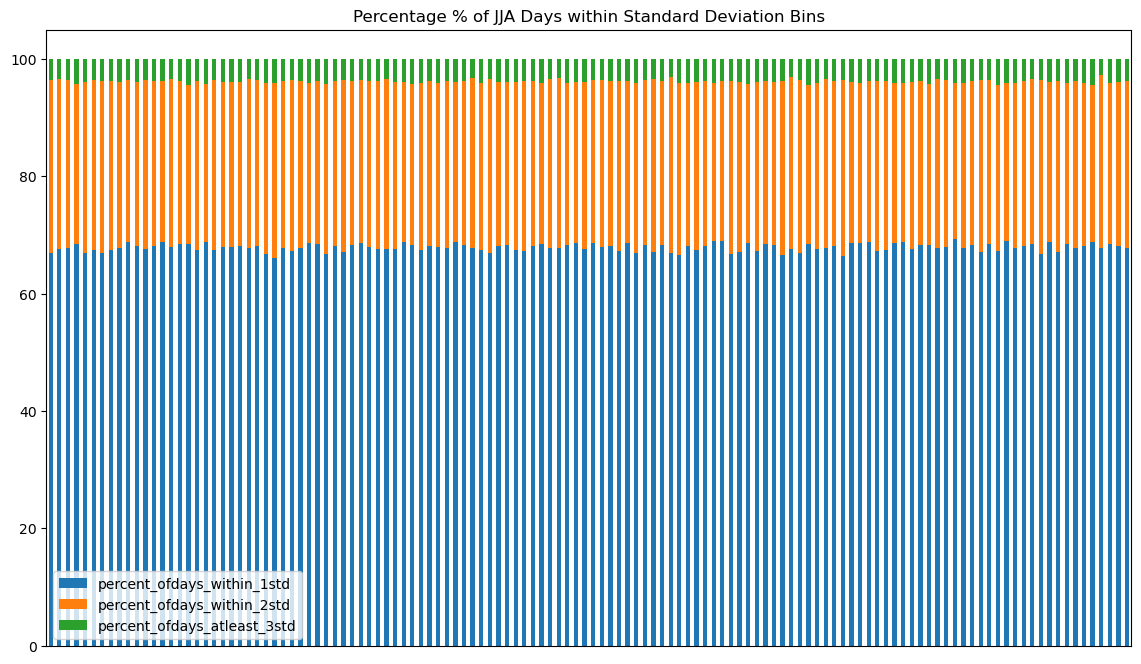

In [409]:
std1 = df_final.groupby('std_bins').station.value_counts().unstack(0).reset_index()
std1 = std1.rename_axis(None, axis=1)
std1['Total'] = std1.sum(axis=1)
std1['percent_ofdays_within_1std'] = (std1[1.0]/std1['Total'])*100
std1['percent_ofdays_within_2std'] = (std1[2.0]/std1['Total'])*100
std1['percent_ofdays_atleast_3std'] = (std1[3.0]/std1['Total'])*100
std1


plt = std1.plot(x='station',
          y = ['percent_ofdays_within_1std', 'percent_ofdays_within_2std', 'percent_ofdays_atleast_3std'], 
          kind='bar', 
          stacked=True, 
          title=f'Percentage % of JJA Days within Standard Deviation Bins', figsize=(14, 8))

plt.xaxis.set_visible(False)
std1


In [747]:
# total: 

tot = df_final.groupby(['std_bins']).size().reset_index(name='counts')
tot['percent_total'] = round(tot['counts']/tot['counts'].sum()*100,1)
tot

print(tot['counts'].sum())
tot

# tot['Non_anomalous_days'] = (tot[1.0]/tot['Total'])*100

259017


,std_bins,counts,percent_total
0,1.0,175810,67.9
1,2.0,73283,28.3
2,3.0,9924,3.8


In [740]:
len(df_final)

262332

In [745]:
len(df_final[~(df_final['temp_2m[C]_anomaly'].isna())])

259017

# COME BACK TO Time Series by Season (no huge trends but could do magnitude)

In [1005]:
# for each season
# try averageing anomaly and not doing std
# CAN CHANGE _ANOMALY VAR TO PLOT JUST TEMPS TO SEE IT


def season_yr(yr):
    df_final[df_final['temp_2m[C]'].isna()]

    df_for_measuring = df_final[['year', 'month','temp_2m[C]_anomaly']][df_final['year'] == yr]
    # df_for_measuring = df_for_measuring[~df_for_measuring['temp_2m[C]_anomaly'].isna()]
    df_cts = df_for_measuring.groupby(['year', 'month']).mean()
    df_cts.reset_index(inplace=True)
    df_cts.rename(columns = {'temp_2m[C]_anomaly':'mean_anomaly'}, inplace = True)


    df_for_normalization = df_final[['year', 'temp_2m[C]_anomaly', 'month']][df_final['year'] == yr]
    df_for_normalization = df_for_normalization[~df_for_normalization['temp_2m[C]_anomaly'].isna()]
    df_norm = df_for_normalization.groupby(['year','month' ]).count()
    df_norm.reset_index(inplace=True)
    df_norm.rename(columns = {'temp_2m[C]_anomaly':'count_totalyear'}, inplace = True)


    mgd = df_cts.merge(df_norm, on = ['year', 'month'], how = 'inner')
    # mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

    mgd['yearseas'] = mgd['month']
    
    time_plot = mgd['yearseas']
    anom_plot = mgd['mean_anomaly']
    
    return time_plot, anom_plot

mos_2017, anom_2017= season_yr('2017')
mos_2018, anom_2018= season_yr('2018')
mos_2019, anom_2019= season_yr('2019')
mos_2020, anom_2020= season_yr('2020')
mos_2021, anom_2021= season_yr('2021')
mos_2022, anom_2022= season_yr('2022')


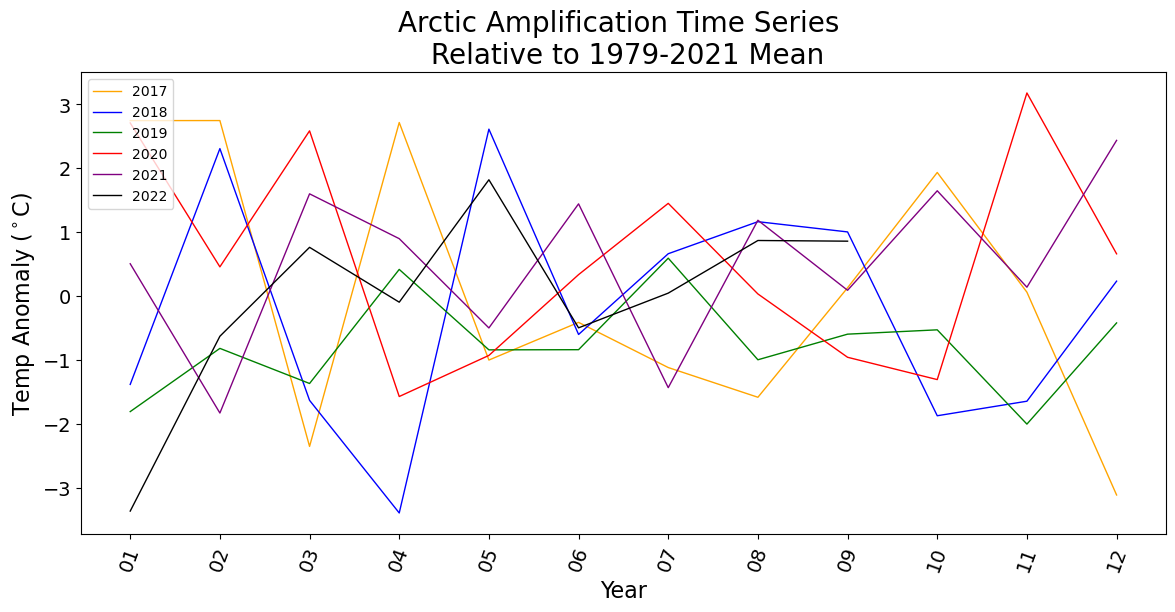

In [1006]:
import matplotlib.pyplot as plt

## Create figure of a particular size
fig = plt.figure(figsize=(14, 6))

## TS Karl
# add plots for TS Karl windspeed
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(mos_2018, anom_2017, label='2017', color='orange',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(mos_2018, anom_2018, label='2018', color='blue',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(mos_2019, anom_2019, label='2019', color='green',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(mos_2020, anom_2020, label='2020', color='red',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(mos_2021, anom_2021, label='2021', color='purple',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(mos_2022, anom_2022, label='2022', color='black',linewidth=1, markersize = 6) #, marker='o'

# ax1.plot(years, spring, label='Spring', color='green',linewidth=1, markersize = 6) # , marker='o'
# ax1.plot(years, summer, label='Summer', color='red',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(years, fall, label='Fall', color='purple',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(years, annual, label='Annual', color='black',linewidth=2, linestyle='--', markersize = 6) #, marker='o'


ax1.set_title('Arctic Amplification Time Series \n Relative to 1979-2021 Mean', size = 20)
ax1.set_xlabel('Year', size = 16)
ax1.set_ylabel('Temp Anomaly ($^\circ$C)', size = 16)
ax1.tick_params(axis='x', labelrotation = 70, labelsize=14)
ax1.tick_params(axis='y',  labelsize=14)

ax1.legend(loc='upper left')

In [977]:
# for each season
# try averageing anomaly and not doing std

def season_yr(seas):
    df_final[df_final['temp_2m[C]'].isna()]

    df_for_measuring = df_final[['year', 'season','temp_2m[C]_anomaly']][df_final['season'] == seas]
    df_for_measuring = df_for_measuring[~df_for_measuring['temp_2m[C]_anomaly'].isna()]
    df_cts = df_for_measuring.groupby(['year', 'season']).mean()
    df_cts.reset_index(inplace=True)
    df_cts.rename(columns = {'temp_2m[C]_anomaly':'mean_anomaly'}, inplace = True)


    df_for_normalization = df_final[['year', 'temp_2m[C]_anomaly', 'season']][df_final['season'] == seas]
    df_for_normalization = df_for_normalization[~df_for_normalization['temp_2m[C]_anomaly'].isna()]
    df_norm = df_for_normalization.groupby(['year','season' ]).count()
    df_norm.reset_index(inplace=True)
    df_norm.rename(columns = {'temp_2m[C]_anomaly':'count_totalyear'}, inplace = True)


    mgd = df_cts.merge(df_norm, on = ['year', 'season'], how = 'inner')
    # mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

    mgd['yearseas'] = mgd['year']+mgd['season']
    
    time_plot = mgd['yearseas']
    anom_plot = mgd['mean_anomaly']
    
    return time_plot, anom_plot

jja_time, jja_anom = season_yr('JJA')
print(type(jja_time))
print(jja_anom)

<class 'pandas.core.series.Series'>
0   -1.051097
1    0.417331
2   -0.411954
3    0.607629
4    0.386541
5    0.144525
Name: mean_anomaly, dtype: float64


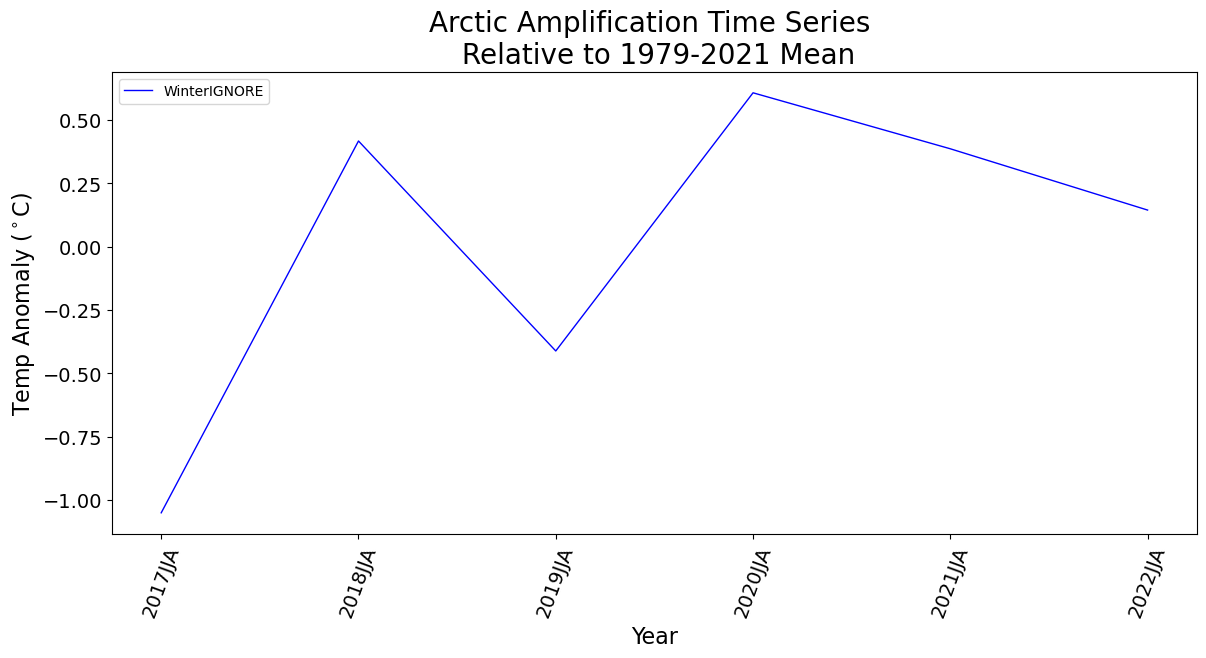

In [978]:
import matplotlib.pyplot as plt

## Create figure of a particular size
fig = plt.figure(figsize=(14, 6))

## TS Karl
# add plots for TS Karl windspeed
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(jja_time, jja_anom, label='WinterIGNORE', color='blue',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(years, spring, label='Spring', color='green',linewidth=1, markersize = 6) # , marker='o'
# ax1.plot(years, summer, label='Summer', color='red',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(years, fall, label='Fall', color='purple',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(years, annual, label='Annual', color='black',linewidth=2, linestyle='--', markersize = 6) #, marker='o'


ax1.set_title('Arctic Amplification Time Series \n Relative to 1979-2021 Mean', size = 20)
ax1.set_xlabel('Year', size = 16)
ax1.set_ylabel('Temp Anomaly ($^\circ$C)', size = 16)
ax1.tick_params(axis='x', labelrotation = 70, labelsize=14)
ax1.tick_params(axis='y',  labelsize=14)

ax1.legend(loc='upper left')

In [965]:
# try averageing anomaly and not doing std

df_final[df_final['temp_2m[C]'].isna()]

df_for_measuring = df_final[['year', 'temp_2m[C]_anomaly']][(df_final['station'] == 'BRON') & (df_final['season'] == 'SON')]
df_for_measuring = df_for_measuring[~df_for_measuring['temp_2m[C]_anomaly'].isna()]
df_cts = df_for_measuring.groupby(['year']).mean()
df_cts.reset_index(inplace=True)
df_cts.rename(columns = {'temp_2m[C]_anomaly':'mean_anomaly'}, inplace = True)


df_for_normalization = df_final[['year', 'temp_2m[C]_anomaly']][(df_final['station'] == 'BRON') & (df_final['season'] == 'SON')]
df_for_normalization = df_for_normalization[~df_for_normalization['temp_2m[C]_anomaly'].isna()]
df_norm = df_for_normalization.groupby(['year', ]).count()
df_norm.reset_index(inplace=True)
df_norm.rename(columns = {'temp_2m[C]_anomaly':'count_totalyear'}, inplace = True)


mgd = df_cts.merge(df_norm, on = 'year', how = 'inner')
# mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

mgd.head()

,year,mean_anomaly,count_totalyear
0,2017,1.214505,80
1,2018,-1.018781,91
2,2019,-0.786531,91
3,2020,0.358092,91
4,2021,0.444198,91


In [958]:
# try averageing anomaly and not doing std
#BRONX

df_final[df_final['temp_2m[C]'].isna()]

df_for_measuring = df_final[['year', 'temp_2m[C]_anomaly', 'season']][df_final['station'] == 'BRON']
df_for_measuring = df_for_measuring[~df_for_measuring['temp_2m[C]_anomaly'].isna()]
df_cts = df_for_measuring.groupby(['year', 'season']).mean()
df_cts.reset_index(inplace=True)
df_cts.rename(columns = {'temp_2m[C]_anomaly':'mean_anomaly'}, inplace = True)


df_for_normalization = df_final[['year', 'temp_2m[C]_anomaly', 'season']][df_final['station'] == 'BRON']
df_for_normalization = df_for_normalization[~df_for_normalization['temp_2m[C]_anomaly'].isna()]
df_norm = df_for_normalization.groupby(['year', 'season']).count()
df_norm.reset_index(inplace=True)
df_norm.rename(columns = {'temp_2m[C]_anomaly':'count_totalyear'}, inplace = True)


mgd = df_cts.merge(df_norm, on = ['year', 'season'], how = 'inner')
# mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

mgd

,year,season,mean_anomaly,count_totalyear
0,2017,DJF,-2.417792,31
1,2017,SON,1.214505,80
2,2018,DJF,0.280631,90
3,2018,JJA,-0.022964,92
4,2018,MAM,-0.709127,92
5,2018,SON,-1.018781,91
6,2019,DJF,-0.706916,90
7,2019,JJA,-0.146702,92
8,2019,MAM,-0.287453,92
9,2019,SON,-0.786531,91


In [989]:
# fractional std away
df_final = df[['date', 'monthday', 'station', 'temp_2m[C]']].merge(b[['monthday', 'station', 'mean', 'std']], how='inner', left_on = ['monthday', 'station'], right_on=['monthday', 'station'])
df_final.rename(columns = {'mean':'temp_2m[C]_mean', 'std':'temp_2m[C]_std'}, inplace = True)
df_final['year'] =  df_final['date'].astype(str).str[0:4]
df_final['month'] =  df_final['date'].astype(str).str[5:7]
season_list = []
months = df_final['month'].to_list()
for mo in months:
    if mo in ['12','01','02']:
        season_list.append('DJF')
    elif mo in ['03','04','05']:
        season_list.append('MAM')
    elif mo in ['06','07','08']:
        season_list.append('JJA')
    else:
        season_list.append('SON')
df_final['season'] = season_list
df_final['temp_2m[C]_anomaly'] = df_final['temp_2m[C]'] - df_final['temp_2m[C]_mean']
df_final['stds_away'] = abs(df_final['temp_2m[C]_anomaly'])/df_final['temp_2m[C]_std']

In [992]:
# try averageing anomaly and not doing std

df_final[df_final['temp_2m[C]'].isna()]

df_for_measuring = df_final[['year', 'stds_away']]
df_for_measuring = df_for_measuring[~df_for_measuring['stds_away'].isna()]
df_cts = df_for_measuring.groupby(['year']).mean()
df_cts.reset_index(inplace=True)
df_cts.rename(columns = {'stds_away':'mean_std_away'}, inplace = True)


df_for_normalization = df_final[['year', 'stds_away']]
df_for_normalization = df_for_normalization[~df_for_normalization['stds_away'].isna()]
df_norm = df_for_normalization.groupby(['year', ]).count()
df_norm.reset_index(inplace=True)
df_norm.rename(columns = {'stds_away':'mean_std_away'}, inplace = True)


mgd = df_cts.merge(df_norm, on = 'year', how = 'inner')
# mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

mgd

# NO EVIDENCE OF INCREASE STD AWAY!

,year,mean_std_away_x,mean_std_away_y
0,2017,0.838566,43121
1,2018,0.826421,45844
2,2019,0.735613,45946
3,2020,0.809524,46021
4,2021,0.781414,45856
5,2022,0.789469,32229


In [998]:
# try averageing anomaly and not doing std
def avgg(seas):
    df_final[df_final['temp_2m[C]'].isna()]

    df_for_measuring = df_final[['year', 'season', 'stds_away']][df_final['season'] == seas]
    df_for_measuring = df_for_measuring[~df_for_measuring['stds_away'].isna()]
    df_cts = df_for_measuring.groupby(['year', 'season']).mean()
    df_cts.reset_index(inplace=True)
    df_cts.rename(columns = {'stds_away':'mean_std_away'}, inplace = True)


    df_for_normalization = df_final[['year', 'stds_away', 'season']][df_final['season'] == seas]
    df_for_normalization = df_for_normalization[~df_for_normalization['stds_away'].isna()]
    df_norm = df_for_normalization.groupby(['year', 'season' ]).count()
    df_norm.reset_index(inplace=True)
    df_norm.rename(columns = {'stds_away':'ct_std_away'}, inplace = True)


    mgd = df_cts.merge(df_norm, on = ['year', 'season'], how = 'inner')
    # mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

    return mgd['year'], mgd['mean_std_away']

timedjf, valdjf = avgg('DJF')
timemam, valmam = avgg('MAM')
timejja, valjja = avgg('JJA')
timeson, valson = avgg('SON')

In [1000]:
valson

0    0.866624
1    0.902556
2    0.714621
3    0.904489
4    0.629077
5    0.489009
Name: mean_std_away, dtype: float64

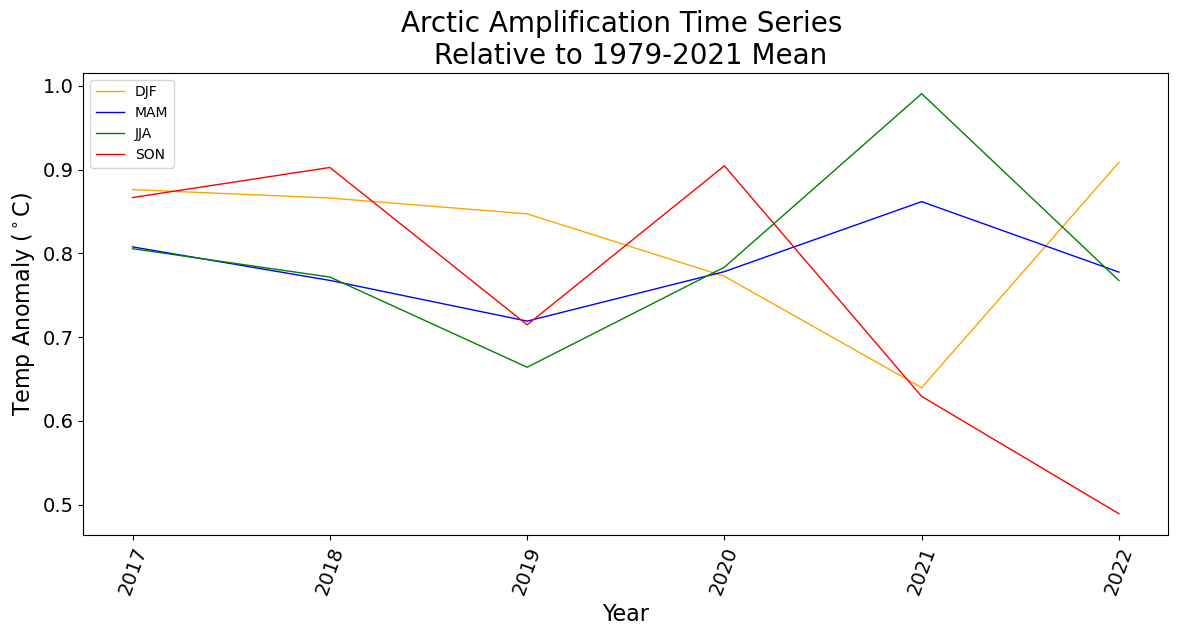

In [1001]:
import matplotlib.pyplot as plt

## Create figure of a particular size
fig = plt.figure(figsize=(14, 6))

## TS Karl
# add plots for TS Karl windspeed
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(timedjf, valdjf, label='DJF', color='orange',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(timemam, valmam, label='MAM', color='blue',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(timejja, valjja, label='JJA', color='green',linewidth=1, markersize = 6) #, marker='o'
ax1.plot(timeson, valson, label='SON', color='red',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(mos_2021, anom_2021, label='2021', color='purple',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(mos_2022, anom_2022, label='2022', color='black',linewidth=1, markersize = 6) #, marker='o'

# ax1.plot(years, spring, label='Spring', color='green',linewidth=1, markersize = 6) # , marker='o'
# ax1.plot(years, summer, label='Summer', color='red',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(years, fall, label='Fall', color='purple',linewidth=1, markersize = 6) #, marker='o'
# ax1.plot(years, annual, label='Annual', color='black',linewidth=2, linestyle='--', markersize = 6) #, marker='o'


ax1.set_title('Arctic Amplification Time Series \n Relative to 1979-2021 Mean', size = 20)
ax1.set_xlabel('Year', size = 16)
ax1.set_ylabel('Temp Anomaly ($^\circ$C)', size = 16)
ax1.tick_params(axis='x', labelrotation = 70, labelsize=14)
ax1.tick_params(axis='y',  labelsize=14)

ax1.legend(loc='upper left')

In [ ]:
# try averageing anomaly and not doing std

df_final[df_final['temp_2m[C]'].isna()]

df_for_measuring = df_final[['year', 'temp_2m[C]_anomaly', 'season']]
df_for_measuring = df_for_measuring[~df_for_measuring['temp_2m[C]_anomaly'].isna()]
df_cts = df_for_measuring.groupby(['year', 'season']).mean()
df_cts.reset_index(inplace=True)
df_cts.rename(columns = {'temp_2m[C]_anomaly':'mean_anomaly'}, inplace = True)


df_for_normalization = df_final[['year', 'temp_2m[C]_anomaly', 'season']]
df_for_normalization = df_for_normalization[~df_for_normalization['temp_2m[C]_anomaly'].isna()]
df_norm = df_for_normalization.groupby(['year', 'season']).count()
df_norm.reset_index(inplace=True)
df_norm.rename(columns = {'temp_2m[C]_anomaly':'count_totalyear'}, inplace = True)


mgd = df_cts.merge(df_norm, on = ['year', 'season'], how = 'inner')
# mgd['relative'] = mgd['count_anomalies']/mgd['count_totalyear']

In [933]:
df_cts['temp_2m[C]_anomaly'].sum()

259017

In [890]:
round((1.974306+1.556117),2)/6.352793

0.5556611084290012

In [898]:
df_final

,date,monthday,station,temp_2m[C],temp_2m[C]_mean,temp_2m[C]_std,year,month,season,temp_2m[C]_anomaly,greater_than_x_stds_away
0,2017-01-01,01-01,ADDI,0.126042,-3.360558,6.257776,2017,01,DJF,3.486600,0.0
1,2018-01-01,01-01,ADDI,-16.729861,-3.360558,6.257776,2018,01,DJF,-13.369303,2.0
2,2019-01-01,01-01,ADDI,4.503125,-3.360558,6.257776,2019,01,DJF,7.863683,1.0
3,2020-01-01,01-01,ADDI,-2.948264,-3.360558,6.257776,2020,01,DJF,0.412294,0.0
4,2021-01-01,01-01,ADDI,-4.305903,-3.360558,6.257776,2021,01,DJF,-0.945345,0.0
...,...,...,...,...,...,...,...,...,...,...,...
262327,2018-12-31,12-31,YORK,-0.008333,-1.556117,6.352793,2018,12,DJF,1.547784,0.0
262328,2019-12-31,12-31,YORK,2.273264,-1.556117,6.352793,2019,12,DJF,3.829381,0.0
262329,2020-12-31,12-31,YORK,1.974306,-1.556117,6.352793,2020,12,DJF,3.530423,0.0
262330,2021-12-31,12-31,YORK,5.020139,-1.556117,6.352793,2021,12,DJF,6.576256,1.0


In [862]:
df_final[90000:90006]

,date,monthday,station,temp_2m[C],temp_2m[C]_mean,temp_2m[C]_relative_std,year,month,season
90000,2017-03-21,03-21,ELMI,4.872917,2.831659,5.248027,2017,03,MAM
90001,2018-03-21,03-21,ELMI,-1.964236,2.831659,5.248027,2018,03,MAM
90002,2019-03-21,03-21,ELMI,5.068403,2.831659,5.248027,2019,03,MAM
90003,2020-03-21,03-21,ELMI,0.658333,2.831659,5.248027,2020,03,MAM
90004,2021-03-21,03-21,ELMI,5.608333,2.831659,5.248027,2021,03,MAM
90005,2022-03-21,03-21,ELMI,6.518403,2.831659,5.248027,2022,03,MAM


In [846]:
len(g)

262332

In [843]:
g = df_final['month'].to_list()
h = g[61112:61117]

for j in g:
    print(h)
    if j in ['03','04', '05']:
        print('hi!')

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [841]:
g[61112:61117]

['05', '05', '05', '05', '05']

In [832]:
listy = ['05', '09']
ff = '05'
if ff in listy:
    print('good!')

good!


In [856]:
df_final[61112:61117]

,date,monthday,station,temp_2m[C],temp_2m[C]_mean,temp_2m[C]_relative_std,year,month,season
61112,2019-05-03,05-03,COLD,11.500694,8.562117,4.354578,2019,05,MAM
61113,2020-05-03,05-03,COLD,13.892014,8.562117,4.354578,2020,05,MAM
61114,2021-05-03,05-03,COLD,11.447917,8.562117,4.354578,2021,05,MAM
61115,2022-05-03,05-03,COLD,10.588194,8.562117,4.354578,2022,05,MAM
61116,2017-05-04,05-04,COLD,6.448611,8.585964,4.370676,2017,05,MAM


In [480]:
df['anomaly_temp_2m[C]'] = df_merge['temp_2m[C]'] - df_merge['rel_day_temp_2m[C]']

In [481]:
df_merge

,date,monthday,station,temp_2m[C],rel_day_temp_2m[C]_count,rel_day_temp_2m[C],anomaly_temp_2m[C]
0,2017-01-01,01-01,ADDI,0.126042,6,-3.360558,3.486600
1,2018-01-01,01-01,ADDI,-16.729861,6,-3.360558,-13.369303
2,2019-01-01,01-01,ADDI,4.503125,6,-3.360558,7.863683
3,2020-01-01,01-01,ADDI,-2.948264,6,-3.360558,0.412294
4,2021-01-01,01-01,ADDI,-4.305903,6,-3.360558,-0.945345
...,...,...,...,...,...,...,...
262327,2018-12-31,12-31,YORK,-0.008333,5,-1.556117,1.547784
262328,2019-12-31,12-31,YORK,2.273264,5,-1.556117,3.829381
262329,2020-12-31,12-31,YORK,1.974306,5,-1.556117,3.530423
262330,2021-12-31,12-31,YORK,5.020139,5,-1.556117,6.576256


## REFERENCE CODE ONLY
#### Ignore..


In [109]:
# call on a coordinate
nysm_ds.station

# call on a varibale
nysm_ds['temp_2m [degC]']

<xarray.DataArray 'temp_2m [degC]' (station: 126, time: 8929)>
array([[23.3, 22.7, 22.5, ..., 18.2, 18.2, 18.2],
       [21.3, 20.4, 19.7, ..., 16.8, 16.5, 16.4],
       [24.1, 24. , 24. , ..., 22.6, 22.6, 22.5],
       ...,
       [24.7, 24.2, 23.5, ..., 14.3, 14.3, 14.4],
       [23.8, 22.9, 22.5, ..., 22.1, 21.8, 21.8],
       [22.8, 22.2, 21.8, ..., 22.9, 22.8, 22.6]])
Coordinates:
  * station  (station) object 'ADDI' 'ANDE' 'BATA' ... 'WHIT' 'WOLC' 'YORK'
  * time     (time) datetime64[ns] 2020-07-31T23:50:00 ... 2020-08-31T23:55:00

In [ ]:
nysm_ds['temp_2m [degC]'].shape

In [29]:
# REFERENCE ONLY
# "data array" . mean ("dimension to average across"... eliminating that dim completely, it's averaged out if left blank, will average over everything to give ONE mean value)
# produces another array whose length depends on what you averaged over!

# example 1
avg_temp_by_day = nysm_ds['temp_2m [degC]'].mean('station')
print(avg_temp_by_day.shape)

# example 2
avg_temp_by_station = nysm_ds['temp_2m [degC]'].mean('time')
print(avg_temp_by_station.shape)

(8929,)
(126,)


In [39]:
# this is just like SQL - using all data, but group certain rows together based on common (i.e. season) and then still want to average over the time dimension so that dim is gone and we're left with station only
test1 = nysm_ds.groupby("time.season").mean("time")

/knight/anaconda_aug22/envs/aug22_env/lib/python3.10/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in true_divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


In [43]:
test1

<xarray.Dataset>
Dimensions:                                (station: 126, date: 32)
Coordinates:
  * station                                (station) object 'ADDI' ... 'YORK'
  * date                                   (date) object 2020-07-31 ... 2020-...
Data variables: (12/28)
    temp_2m [degC]                         (station, date) float64 23.3 ... 1...
    temp_9m [degC]                         (station, date) float64 23.5 ... 1...
    relative_humidity [percent]            (station, date) float64 57.1 ... 80.6
    precip_incremental [mm]                (station, date) float64 0.0 ... 0.0
    precip_local [mm]                      (station, date) float64 0.0 ... 0....
    precip_max_intensity [mm/min]          (station, date) float64 0.0 ... 0.0
    ...                                     ...
    soil_temp_05cm [degC]                  (station, date) float64 22.1 ... 1...
    soil_temp_25cm [degC]                  (station, date) float64 20.1 ... 2...
    soil_temp_50cm [degC]                  (station, date) float64 19.1 ... 2...
    soil_moisture_05cm [m^3/m^3]           (station, date) float64 0.08 ... 0...
    soil_moisture_25cm [m^3/m^3]           (station, date) float64 0.2 ... 0....
    soil_moisture_50cm [m^3/m^3]           (station, date) float64 0.27 ... 0.21

In [38]:
test2= nysm_ds.groupby("time.season")
type(test2)

xarray.core.groupby.DatasetGroupBy

In [10]:
ds_sub = nysm_ds.sel(time=nysm_ds.time.dt.month.isin([4]))

In [13]:
nysm_ds.time.dt.date

<xarray.DataArray 'date' (time: 8929)>
array([datetime.date(2020, 7, 31), datetime.date(2020, 8, 1),
       datetime.date(2020, 8, 1), ..., datetime.date(2020, 8, 31),
       datetime.date(2020, 8, 31), datetime.date(2020, 8, 31)],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2020-07-31T23:50:00 ... 2020-08-31T23:55:00

In [99]:
# REFERENCE -- Check that this rolling average is working correctly, not getting mixed up by sites or anything

# SUBSET DATASET: https://stackoverflow.com/questions/38846323/python-xarray-dataset-sel-select-multiple-values-along-one-dimension
# way 1
y = ds_avg_by_site_date.where(ds_avg_by_site_date.station=='WOLC', drop = True)#, "date" :'2020-08-06'})
y

# way 2 (using sel and also datetime issue)
# Using .sel (datetime format issue..)
# g = ds_avg_by_site_date.sel(ds_avg_by_site_date.date == dt.date(2020, 7, 31)) # DATETIME ISSUE
# g

# print out the temps for WOLC then avg in cell below to make sure it works
y["temp_2m [degC]"]

<xarray.DataArray 'temp_2m [degC]' (station: 1, date: 32)>
array([[23.8       , 22.29583333, 25.55173611, 23.64409722, 20.59097222,
        20.34097222, 18.16458333, 19.39201389, 21.21284722, 22.58715278,
        25.67291667, 26.40486111, 22.86041667, 21.67986111, 22.54895833,
        22.99444444, 22.41805556, 20.709375  , 19.25034722, 18.06284722,
        18.01909722, 20.62152778, 22.36423611, 23.75208333, 24.45972222,
        23.28298611, 18.26666667, 20.33854167, 20.16666667, 21.65798611,
        18.71840278, 17.40381944]])
Coordinates:
  * station  (station) object 'WOLC'
  * date     (date) object 2020-07-31 2020-08-01 ... 2020-08-30 2020-08-31

In [8]:
num = 23.8 +22.29583333+25.55173611+23.64409722+20.59097222
num/5

23.176527776

In [9]:
# check that this was the first non nan value for WOLC
# rolling_5day_avg
rolling_5day_avg.where(rolling_5day_avg.station=='WOLC', drop = True) # confirmed! the first value is 23.18

<xarray.Dataset>
Dimensions:                                (station: 1, date: 32)
Coordinates:
  * station                                (station) object 'WOLC'
  * date                                   (date) object 2020-07-31 ... 2020-...
Data variables: (12/28)
    temp_2m [degC]                         (station, date) float64 nan ... nan
    temp_9m [degC]                         (station, date) float64 nan ... nan
    relative_humidity [percent]            (station, date) float64 nan ... nan
    precip_incremental [mm]                (station, date) float64 nan ... nan
    precip_local [mm]                      (station, date) float64 nan ... nan
    precip_max_intensity [mm/min]          (station, date) float64 nan ... nan
    ...                                     ...
    soil_temp_05cm [degC]                  (station, date) float64 nan ... nan
    soil_temp_25cm [degC]                  (station, date) float64 nan ... nan
    soil_temp_50cm [degC]                  (station, date) float64 nan ... nan
    soil_moisture_05cm [m^3/m^3]           (station, date) float64 nan ... nan
    soil_moisture_25cm [m^3/m^3]           (station, date) float64 nan ... nan
    soil_moisture_50cm [m^3/m^3]           (station, date) float64 nan ... nan

#### Reference only 11/27: manually creating rolling dates read in

In [ ]:
# method 1
datetime_mmyy = datetime.strptime('02-04', '%m-%d')
datetime_mmyy

In [ ]:
# back to method 1
def date_string(date_val):
    return f"{'{:02d}'.format(date_val.month)}{'{:02d}'.format(date_val.day)}"


def read_csv_rolling(centerdate, numdays): # change numdays to rolling_half
    dateList = []
    for x in range (0, numdays+1):
        if x == 0:
            center_date = date_string(centerdate)
            dateList.append(center_date)
        else:
            prior_date = date_string(centerdate - timedelta(days = x))
            dateList.append(prior_date)
            next_date = date_string(centerdate + timedelta(days = x))
            dateList.append(next_date)
    return dateList

day_range_read = read_csv_rolling(datetime_mmyy, 7)

print(day_range_read)
print(len(day_range_read))


In [ ]:
%%time 

li = []

for day in day_range_read:
    # list files for a given day, e.g. if day is 0204, this will list mesonet csv data for 20160204, 20170204, ... 20220204
    all_files = glob(f"{path}*{day}.csv")

    # for each file (year) in list, read in the data csv data and append it to outer list
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

nysm_data = pd.concat(li, axis=0, ignore_index=True)


In [ ]:
# method 1
# set station and time to be indices of the df so that the conversion to xarray dataset makes them coordinates
nysm_data = nysm_data.set_index(["station", "time"])

# convert to dataset
nysm_ds = nysm_data.to_xarray()

# convert time coordinate of the dataset to datetime format
# NOTE: must be executed twice (last subcomment here by Vinod: https://stackoverflow.com/questions/62572678/xarray-coords-conversion-to-datetime64)
nysm_ds["time"] = pd.DatetimeIndex(nysm_ds["time"].values)
nysm_ds["time"] = pd.DatetimeIndex(nysm_ds["time"].values)

nysm_ds

In [203]:
# issue subsetting slicing by dates

ds_avg_by_site_date.sel(station = 'BATA', date in (datetime.date(2017, 1, 1), datetime.date(2017, 1, 3)))#['temp_2m[C]'].values

SyntaxError: positional argument follows keyword argument (3043326369.py, line 3)

In [ ]:
import xarray as xr
import numpy as np
data = xr.DataArray([1, 2, 3], dims='x', coords={'x': [10, 20, 30]})
# data
data_newcoord = data.assign_coords(y='newvaluee')
# data
data_expanded = data_newcoord.expand_dims('y')
data_expanded
# print(data_expanded)

In [ ]:
nysm_ds["time.month"]

In [ ]:
m = ds['date.month']
d = ds['date.day']
t = ds['date.date']


# day_ = m+d
# day_

mo_day = []
for i in range(0, len(ds['date'])):
    day = f"{'{:02d}'.format(ds['date.month'][i].values.item())}{'{:02d}'.format(ds['date.day'][i].values.item())}"
    mo_day.append(day)


In [ ]:
ds['yeartry'] = ds["date.year"]
ds['monttry'] = ds["date.month"]
ds['daytry'] = ds["date.day"]

ds2 = ds.assign_coords(coor_yr=ds["date.year"],coor_mo=ds["date.month"],coor_day=ds["date.day"])



In [ ]:
ds2.swap_dims({'date':'yeartry' }).drop('date')

In [ ]:
import xarray as xr

data_newcoord = data.assign_coords(y='coord_value')
data_expanded = data_newcoord.expand_dims('y')
print(data_expanded)

dsavg2 = ds.mean(dim="date.year", skipna=True)

In [53]:
ds

<xarray.Dataset>
Dimensions:             (station: 126, year: 2, date: 730)
Coordinates:
  * station             (station) object 'ADDI' 'ANDE' 'BATA' ... 'WOLC' 'YORK'
  * year                (year) object '2017' '2018'
  * date                (date) datetime64[ns] 2017-01-01 ... 2018-12-31
Data variables:
    temp_2m[C]          (station, year, date) float64 0.126 -1.302 ... -0.008333
    rolling_temp_2m[C]  (station, year, date) float64 nan nan nan ... nan nan

In [60]:
ds["date.month"]

<xarray.DataArray 'month' (date: 730)>
array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12,
...
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12])
Coordinates:
  * date     (date) datetime64[ns] 2017-01-01 2017-01-02 ... 2018-12-31

In [54]:
ds_new = ds


In [ ]:
ds_new.assign_coords(mo_day=(((ds.date + 180) % 360) - 180))

#### Ideas for averageing over hyear which ended up doing in df
#### split the date which is currently year_month_day into 1)year and 2) month_day 
    - then I can average over year
#### OR if there is a way to "call on" the month_day from the date coordinate (like we did in group by functions above) we can use the groupby way

# work with group by and std and resetting columns

In [ ]:
df_anom_monthday = df_sub.groupby(['monthday', 'station']).agg(['count','mean', lambda x: np.std(x, ddof=0)])
df_anom_monthday.reset_index(inplace=True)
#rename columns 
mi = df_anom_monthday.columns
ind = pd.Index([e[0] + e[1] for e in mi.tolist()])
df_anom_monthday.columns = ind
df_anom_monthday.rename(columns = {'rolling_temp_2m[C]mean':'rel_day_temp_2m[C]'}, inplace = True)
df_anom_monthday.rename(columns = {'rolling_temp_2m[C]<lambda_0>':'rel_day_temp_2m[C]_std'}, inplace = True)
df_anom_monthday.rename(columns = {'rolling_temp_2m[C]count':'rel_day_temp_2m[C]_count'}, inplace = True)
print(df_anom_monthday.head())
# print(f"count month|stations with no relative temp (i.e. nan for all 6 years at that station and day) -- count {len(df_anom_monthday['rel_day_temp_2m[C]'][df_anom_monthday['rel_day_temp_2m[C]'].isna()])}")

# Note: for 1/1, there should be 5 years (not 6!) b/c the first year of data 2017 wouldn't have prior 7 days of data


# helpful print statements
print(len(df_anom_monthday))

# count the number of station|days where <5 years
print(df_anom_monthday[df_anom_monthday['rel_day_temp_2m[C]_count'] > 5].shape)
print(df_anom_monthday[df_anom_monthday['rel_day_temp_2m[C]_count'] > 4].shape)
print(df_anom_monthday[df_anom_monthday['rel_day_temp_2m[C]_count'] == 0])

df_merge = df[['date', 'monthday', 'station', 'temp_2m[C]']].merge(df_anom_monthday, how='inner', left_on = ['monthday', 'station'], right_on=['monthday', 'station'])
# df_final= df_merge.merge(df_count_monthday, how='inner', left_on = ['monthday', 'station'], right_on=['monthday', 'station'])

In [ ]:
mi = df_anom_monthday.columns
ind = pd.Index([e[0] + e[1] for e in mi.tolist()])
ind

In [ ]:


v = df[(df['station'] =='BATA') & (df['monthday'] == '01-24')]['rolling_temp_2m[C]'].to_list()
v

In [ ]:
np.std(v, ddof = 0)
np.std(v, ddof = 1) # pandas (if just do "std" in agg in group by... uses 1 delta degrees of freedom so divide by N-1. Point of doing n-1 is b/c our sample is different than pop so it's underestimating the variation in public, thus "fix" by making the std larger)
# https://stackoverflow.com/questions/47676250/pandas-agg-function-gives-different-results-for-numpy-std-vs-nanstd

In [ ]:
df_sub.head()
b = df_sub.groupby(['monthday', 'station']).agg({'rolling_temp_2m[C]_mean':'mean', 'sum_xi_sq':'sum', 'included':'count'}) # once I have multiple cols in my df should be able to do different things to each

b.reset_index(inplace=True)
b.rename(columns = {'rolling_temp_2m[C]_mean': 'mean','sum_xi_sq': 'sum' , 'included': 'ct'}, inplace = True)
# b.rename(columns = {'testcol':'var'}, inplace = True)

b['var_day'] = np.sqrt(b['sum']/(15*b['ct']) - b['mean'])

In [ ]:
# # wrong way on train
# def meansquare_x15(x): #  myfn has to aggregate values somehow b/c it's built in that it's taking in ROWS. Input to this function is a datafrme. When pairing this function with .agg, it knows to go through each row of df, this is buult in. Thus it is a necessaity that the output (return) of my function MUST AGGREGATE, i.e. sum, diff, mean, etc. Will get an error if not!
#     return sum((x**2)*15)

# def var_x15(x): #  myfn has to aggregate values somehow b/c it's built in that it's taking in ROWS. Input to this function is a datafrme. When pairing this function with .agg, it knows to go through each row of df, this is buult in. Thus it is a necessaity that the output (return) of my function MUST AGGREGATE, i.e. sum, diff, mean, etc. Will get an error if not!
#     return sum((x)*15)
    
# b = df_sub.groupby(['monthday', 'station']).agg({'rolling_temp_2m[C]_mean':meansquare_x15, 'rolling_temp_2m[C]_var':var_x15, 'included':'count'}) # once I have multiple cols in my df should be able to do different things to each

# b.reset_index(inplace=True)
# b.rename(columns = {'rolling_temp_2m[C]_mean': 'mean_squared_x15','rolling_temp_2m[C]_var':'var_x15' }, inplace = True)
# # b.rename(columns = {'testcol':'var'}, inplace = True)

# b['var_day'] = np.sqrt((b['mean_squared_x15']+b['var_x15'])/(15*b['included']))

